# Mortgage Loan Rates Forecast Model

# Data Engineering 

## Import Libraries

In [1]:
# Load API key and secret from environment variables
from dotenv import load_dotenv
load_dotenv()

# System libraries
import glob

# ML libraries
import pandas as pd

# ValidMind libraries 
import validmind as vm

# Plotting libraries 

## Data Collection

#### Load FRED Data

In [2]:
def merge_fred_csv_files(file_pattern):
    # Use glob to find all files matching the specified pattern
    file_list = glob.glob(file_pattern)

    # Initialize an empty list to store individual DataFrames
    dataframes = []

    # Iterate through each file in the file list
    for file in file_list:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file, parse_dates=['DATE'], index_col='DATE')

        # Add the DataFrame to the list of DataFrames
        dataframes.append(df)

    # Merge all the DataFrames in the list into a single DataFrame
    merged_df = pd.concat(dataframes, axis=1)

    return merged_df

In [3]:
file_path = '../datasets/fred/*.csv'
fred_df = merge_fred_csv_files(file_path)
display(fred_df)

,GDPC1,GS5,GS10,GS3,MORTGAGE30US,UNRATE,CPIAUCSL,FEDFUNDS,GDP
DATE,,,,,,,,,
1947-01-01,2034.450,NaN,NaN,NaN,NaN,NaN,21.48,NaN,243.164
1947-02-01,NaN,NaN,NaN,NaN,NaN,NaN,21.62,NaN,NaN
1947-03-01,NaN,NaN,NaN,NaN,NaN,NaN,22.00,NaN,NaN
1947-04-01,2029.024,NaN,NaN,NaN,NaN,NaN,22.00,NaN,245.968
1947-05-01,NaN,NaN,NaN,NaN,NaN,NaN,21.95,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-04-01,NaN,NaN,3.46,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-06,NaN,NaN,NaN,NaN,6.28,NaN,NaN,NaN,NaN
2023-04-13,NaN,NaN,NaN,NaN,6.27,NaN,NaN,NaN,NaN


### Preselection of Variables

In [4]:
target_column = ['MORTGAGE30US']
feature_columns = ['UNRATE', 'GS10', 'FEDFUNDS']
fred_df = fred_df[target_column + feature_columns]
display(fred_df)

,MORTGAGE30US,UNRATE,GS10,FEDFUNDS
DATE,,,,
1947-01-01,NaN,NaN,NaN,NaN
1947-02-01,NaN,NaN,NaN,NaN
1947-03-01,NaN,NaN,NaN,NaN
1947-04-01,NaN,NaN,NaN,NaN
1947-05-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-04-01,NaN,NaN,3.46,NaN
2023-04-06,6.28,NaN,NaN,NaN
2023-04-13,6.27,NaN,NaN,NaN


## ValidMind Setup

In [5]:
vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "e22b89a6b9c2a27da47cb0a09febc001",
  api_secret = "a61be901b5596e3c528d94231e4a3c504ef0bb803d16815f8dfd6857fac03e57",
  project = "clgo0g0rt0000fjy6ozl9pb69"
)
  

True

In [6]:
df = fred_df
vm_dataset = vm.init_dataset(dataset=df)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


## Data Description

## Data Quality

### Frequency of the Series

**Handling Frequencies**

In [7]:
df = df.resample('MS').last()
vm_dataset = vm.init_dataset(dataset=df)

Pandas dataset detected. Initializing VM Dataset instance...
Inferring dataset types...


# Exploratory Data Analysis

## Univariate Analysis

In [8]:
vm.test_plans.describe_plan("time_series_univariate")

Attribute,Value
ID,time_series_univariate
Name,TimeSeriesUnivariate
Description,Test plan to perform univariate inspection tests.
Required Context,['dataset']
Tests,"TimeSeriesLinePlot (Metric), TimeSeriesHistogram (Metric), ACFandPACFPlot (Metric), SeasonalDecompose (Metric), AutoSeasonality (Metric), AutoStationarity (Metric), RollingStatsPlot (Metric), AutoAR (Metric), AutoMA (Metric)"
Test Plans,[]


In [9]:
test_plan_config = {
    "time_series_line_plot": {
        "columns": target_column + feature_columns
    },
    "time_series_histogram": {
        "columns": target_column + feature_columns
    },
    "acf_pacf_plot": {
        "columns": target_column + feature_columns
    },
    "auto_ar": {
        "max_ar_order": 3
    },
    "auto_ma": {
        "max_ma_order": 3
    },
    "seasonal_decompose": {
        "seasonal_model": 'additive',
         "fig_size": (40,30)
    },
    "auto_seasonality": {
        "min_period": 1,
        "max_period": 3
    },
      "auto_stationarity": {
        "max_order": 3,
        "threshold": 0.05
    },
      "rolling_stats_plot": {
        "window_size": 12    
    },
}

Running Metric: seasonal_decompose:  33%|███▎      | 3/9 [00:01<00:02,  2.35it/s]The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
Running Metric: auto_ma:  89%|████████▉ | 8/9 [00:03<00:00,  1.90it/s]           Non-invertible starting MA

Non-invertible starting MA parameters found. Using zeros as starting parameters.


Non-invertible starting MA parameters found. Using zeros as starting parameters.
Non-invertible starting MA parameters found. Using zeros as starting parameters.



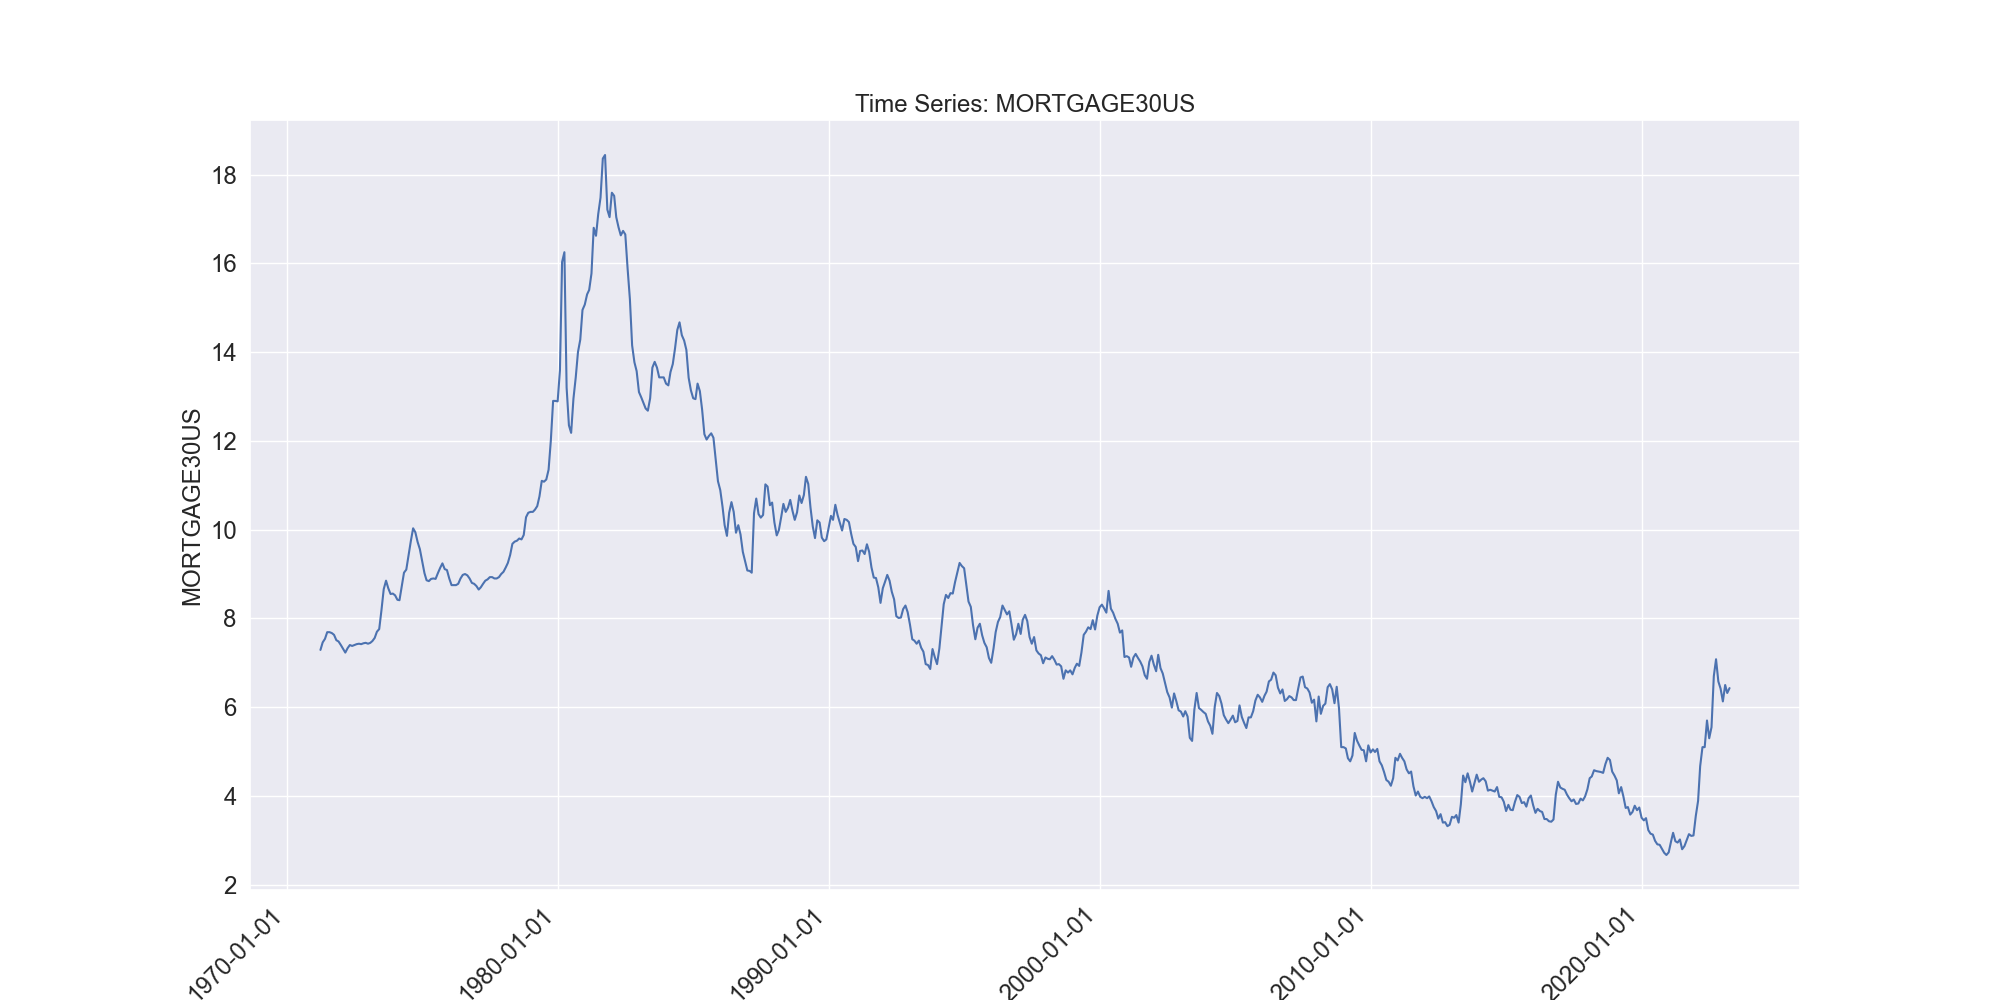
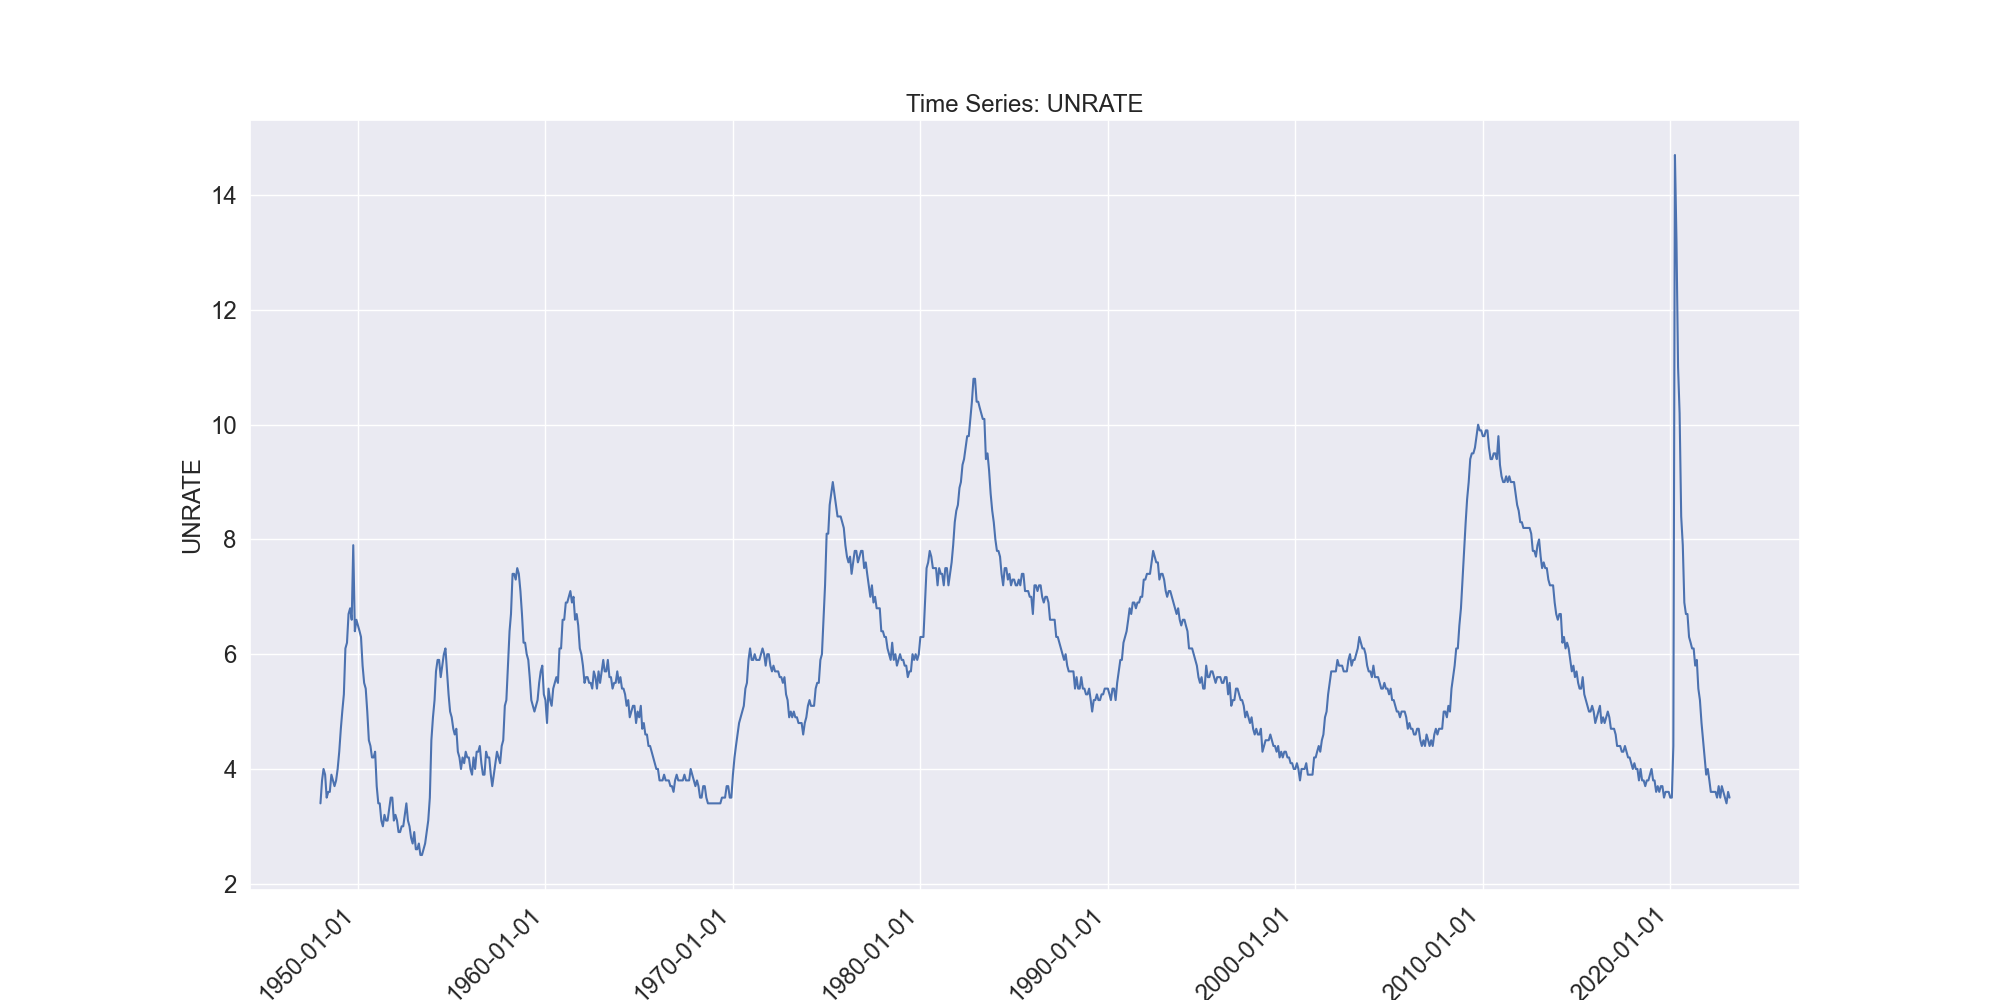
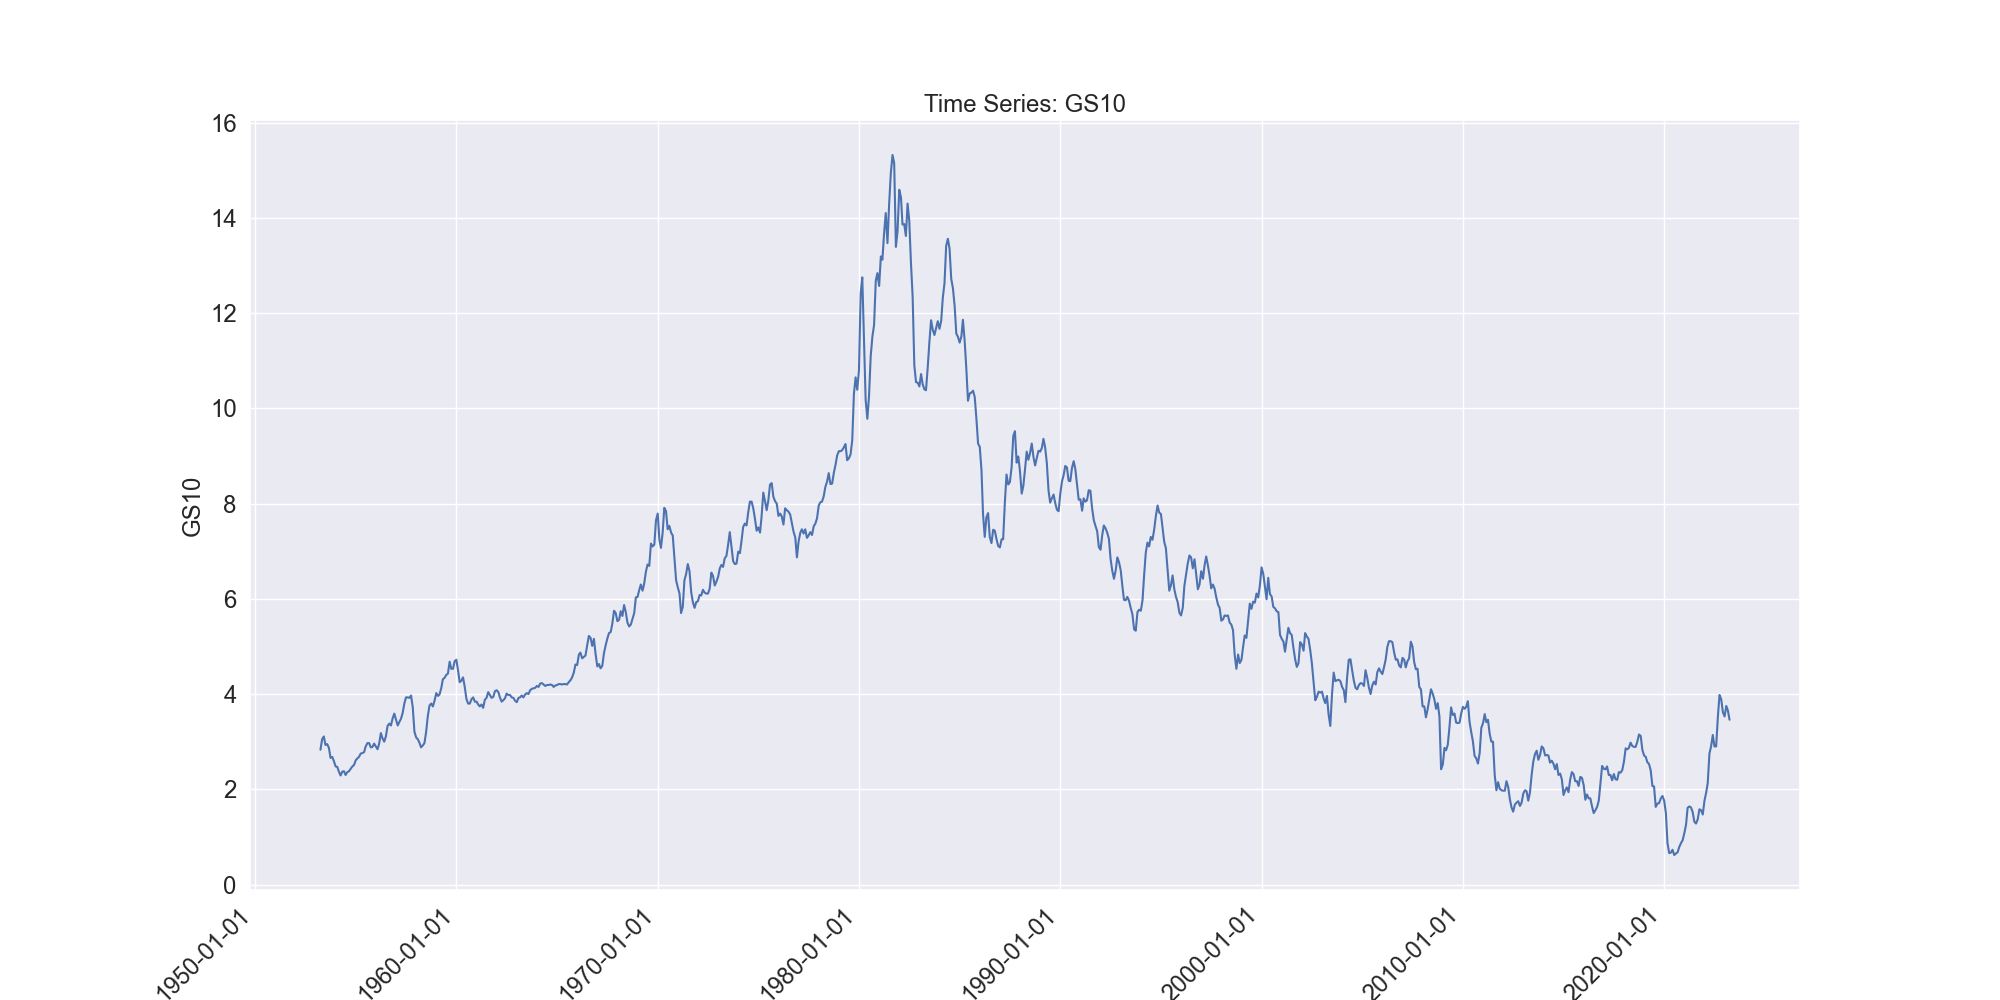
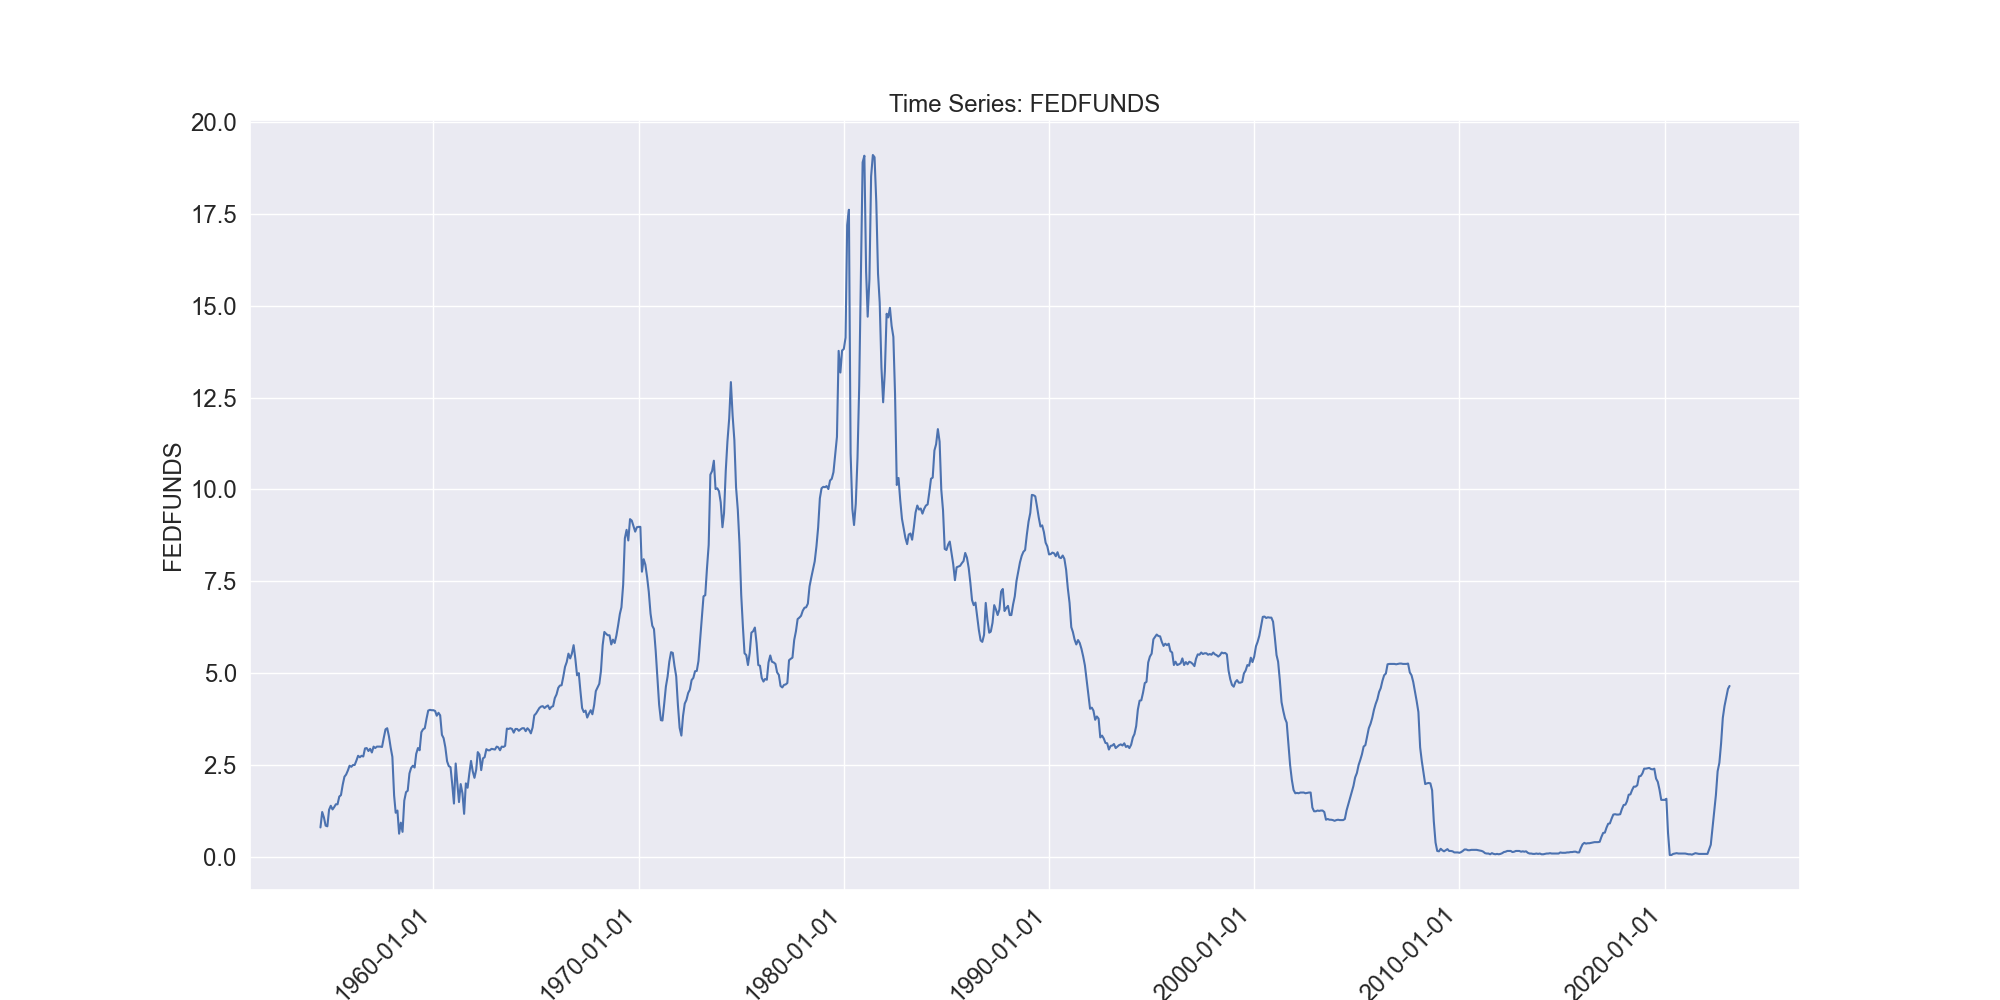
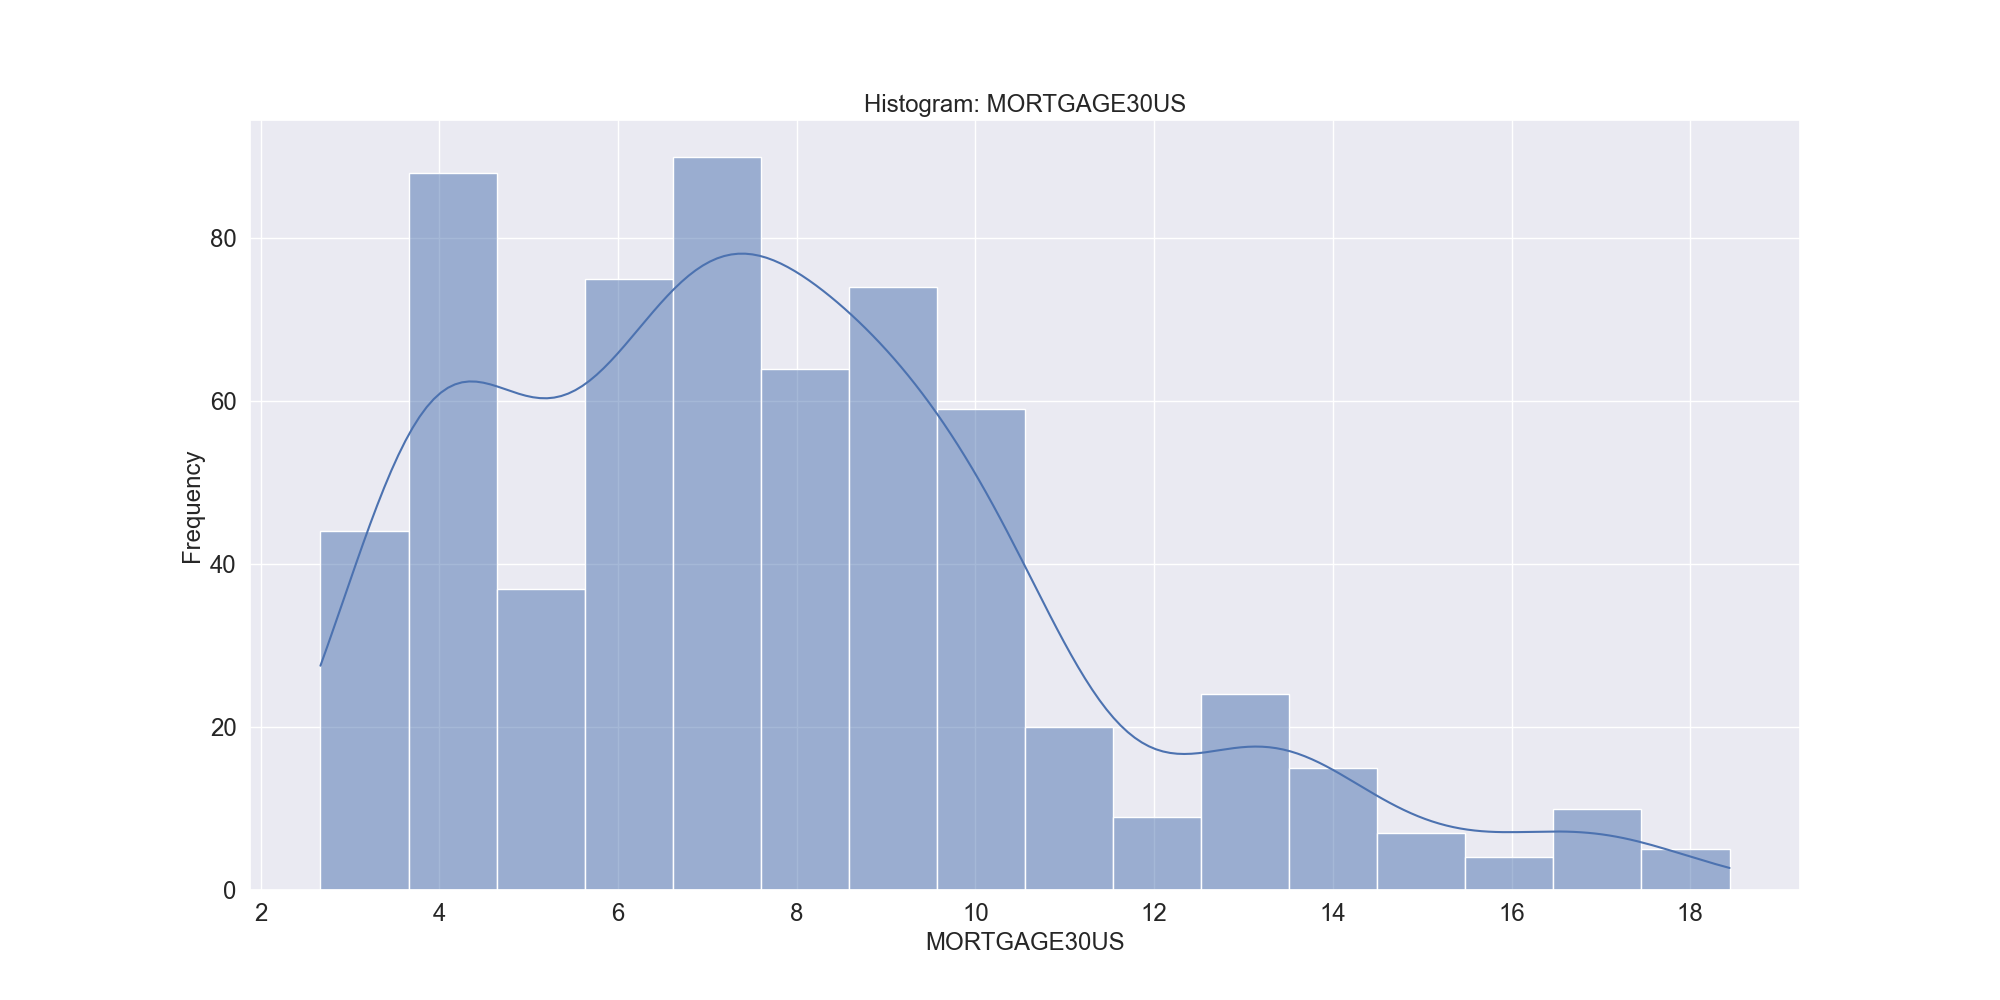
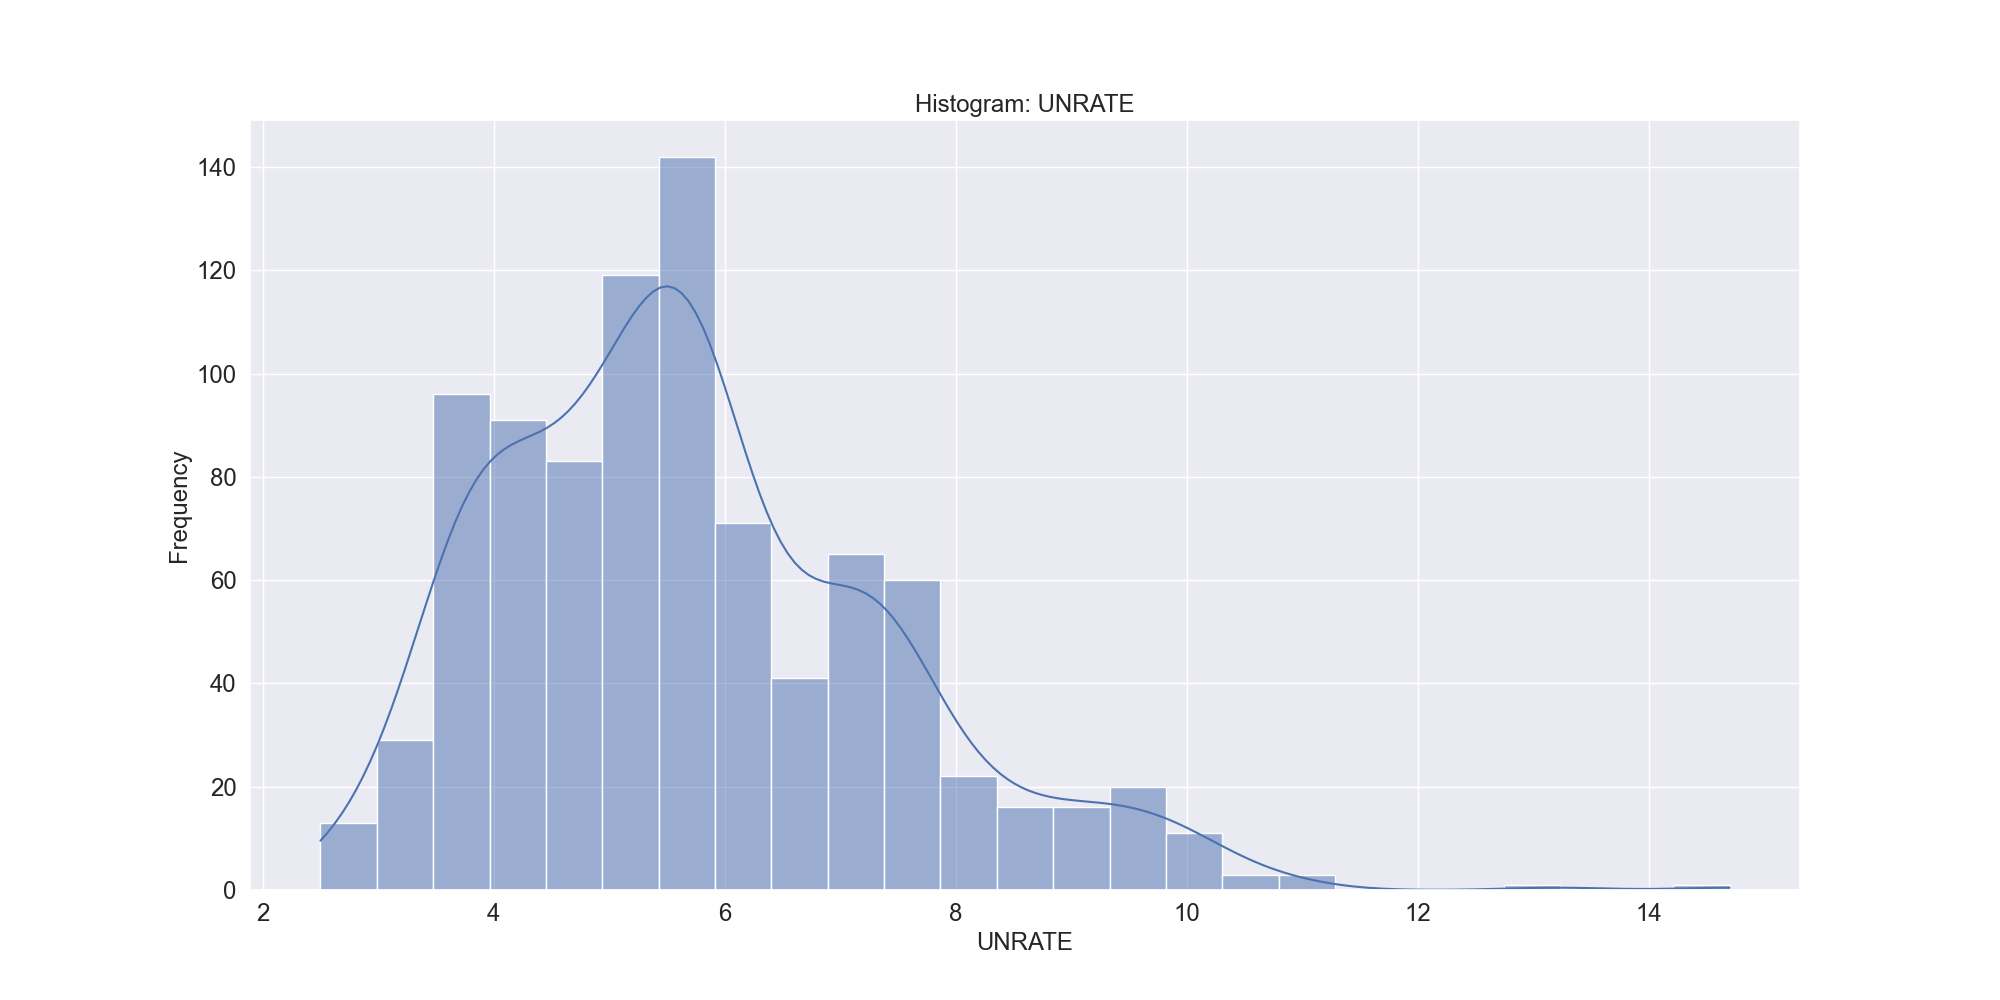
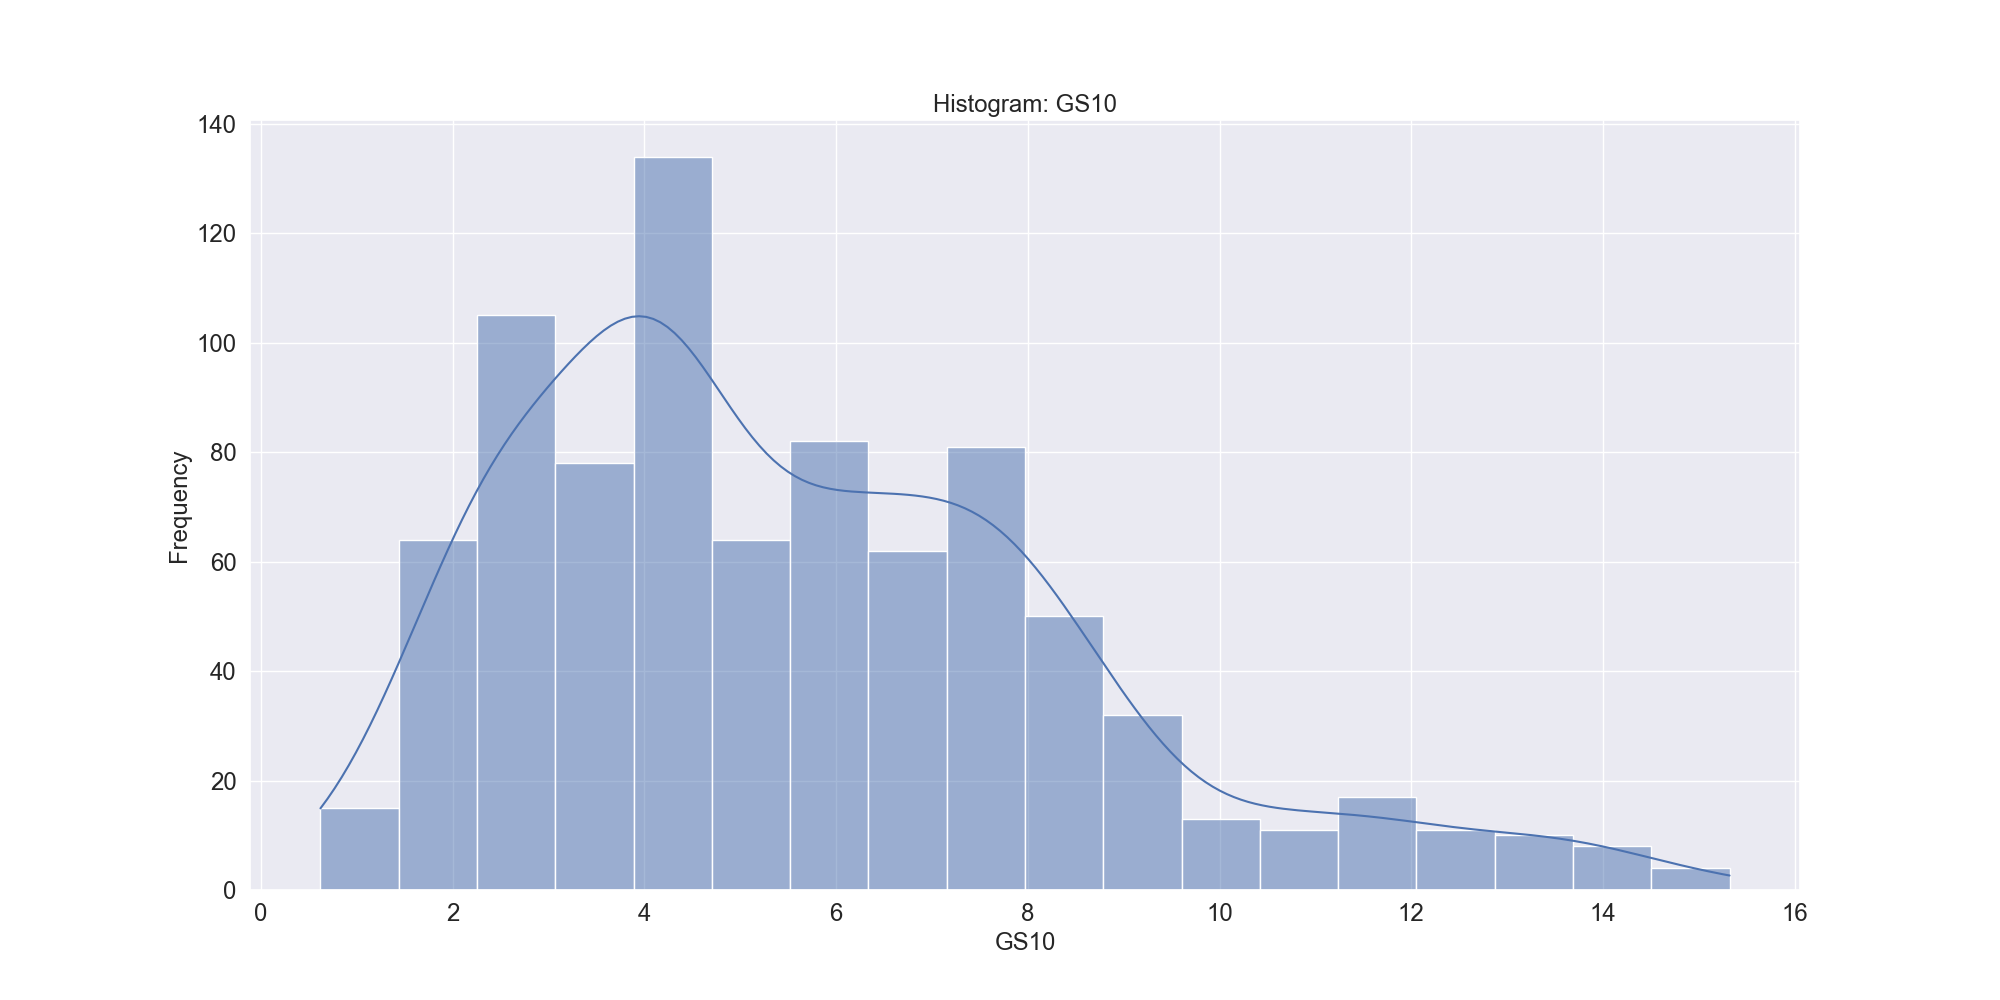
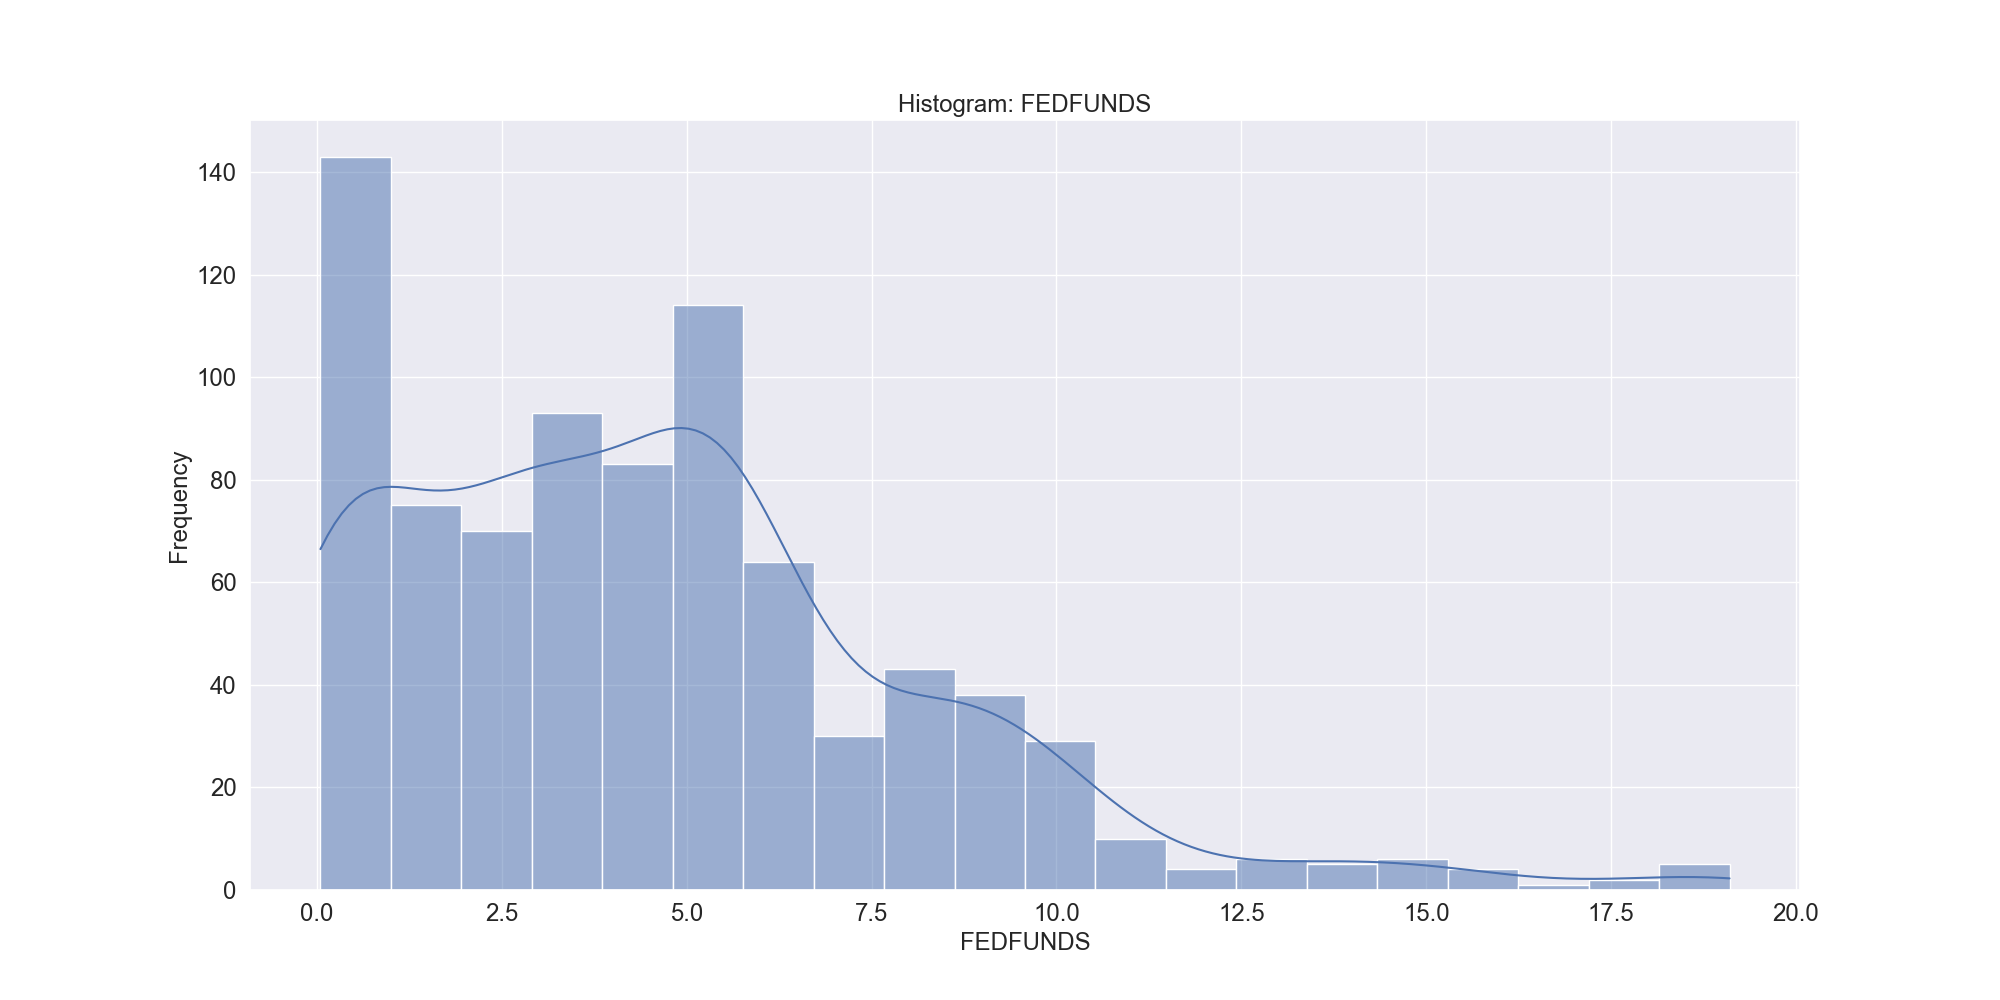
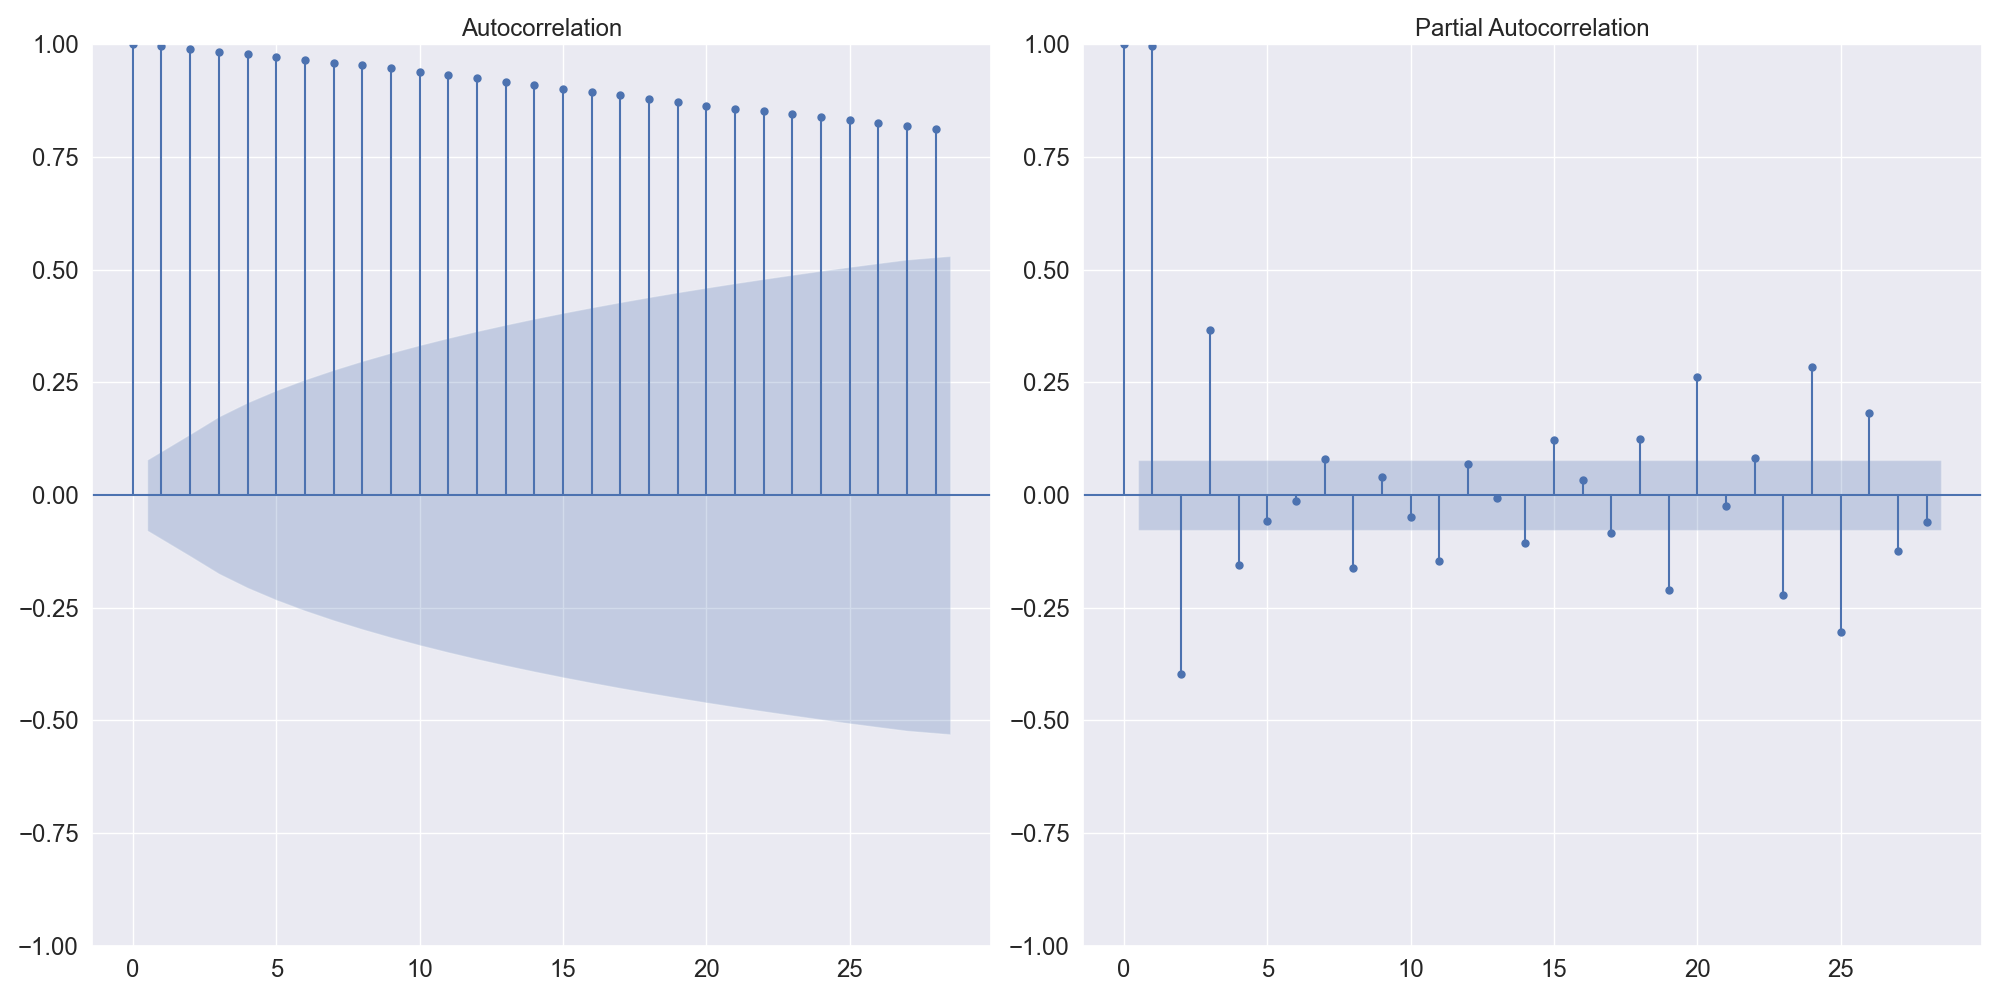
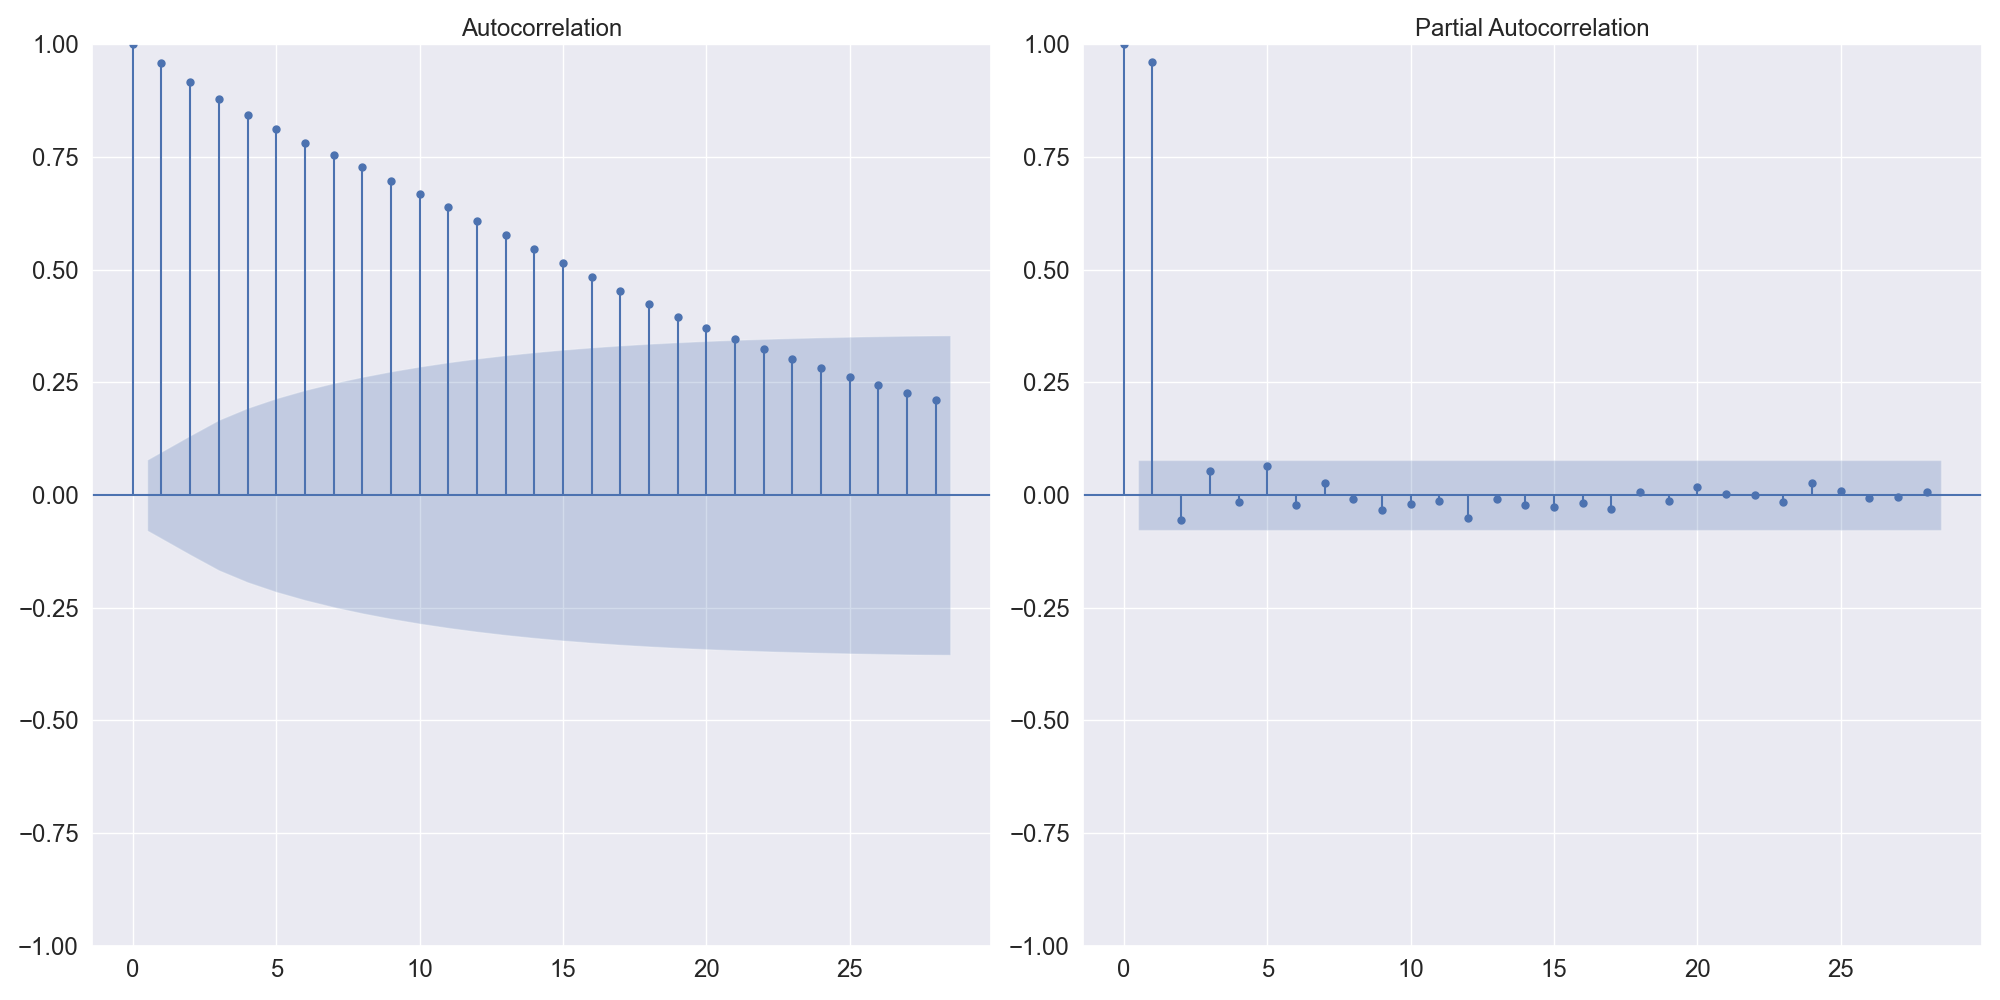
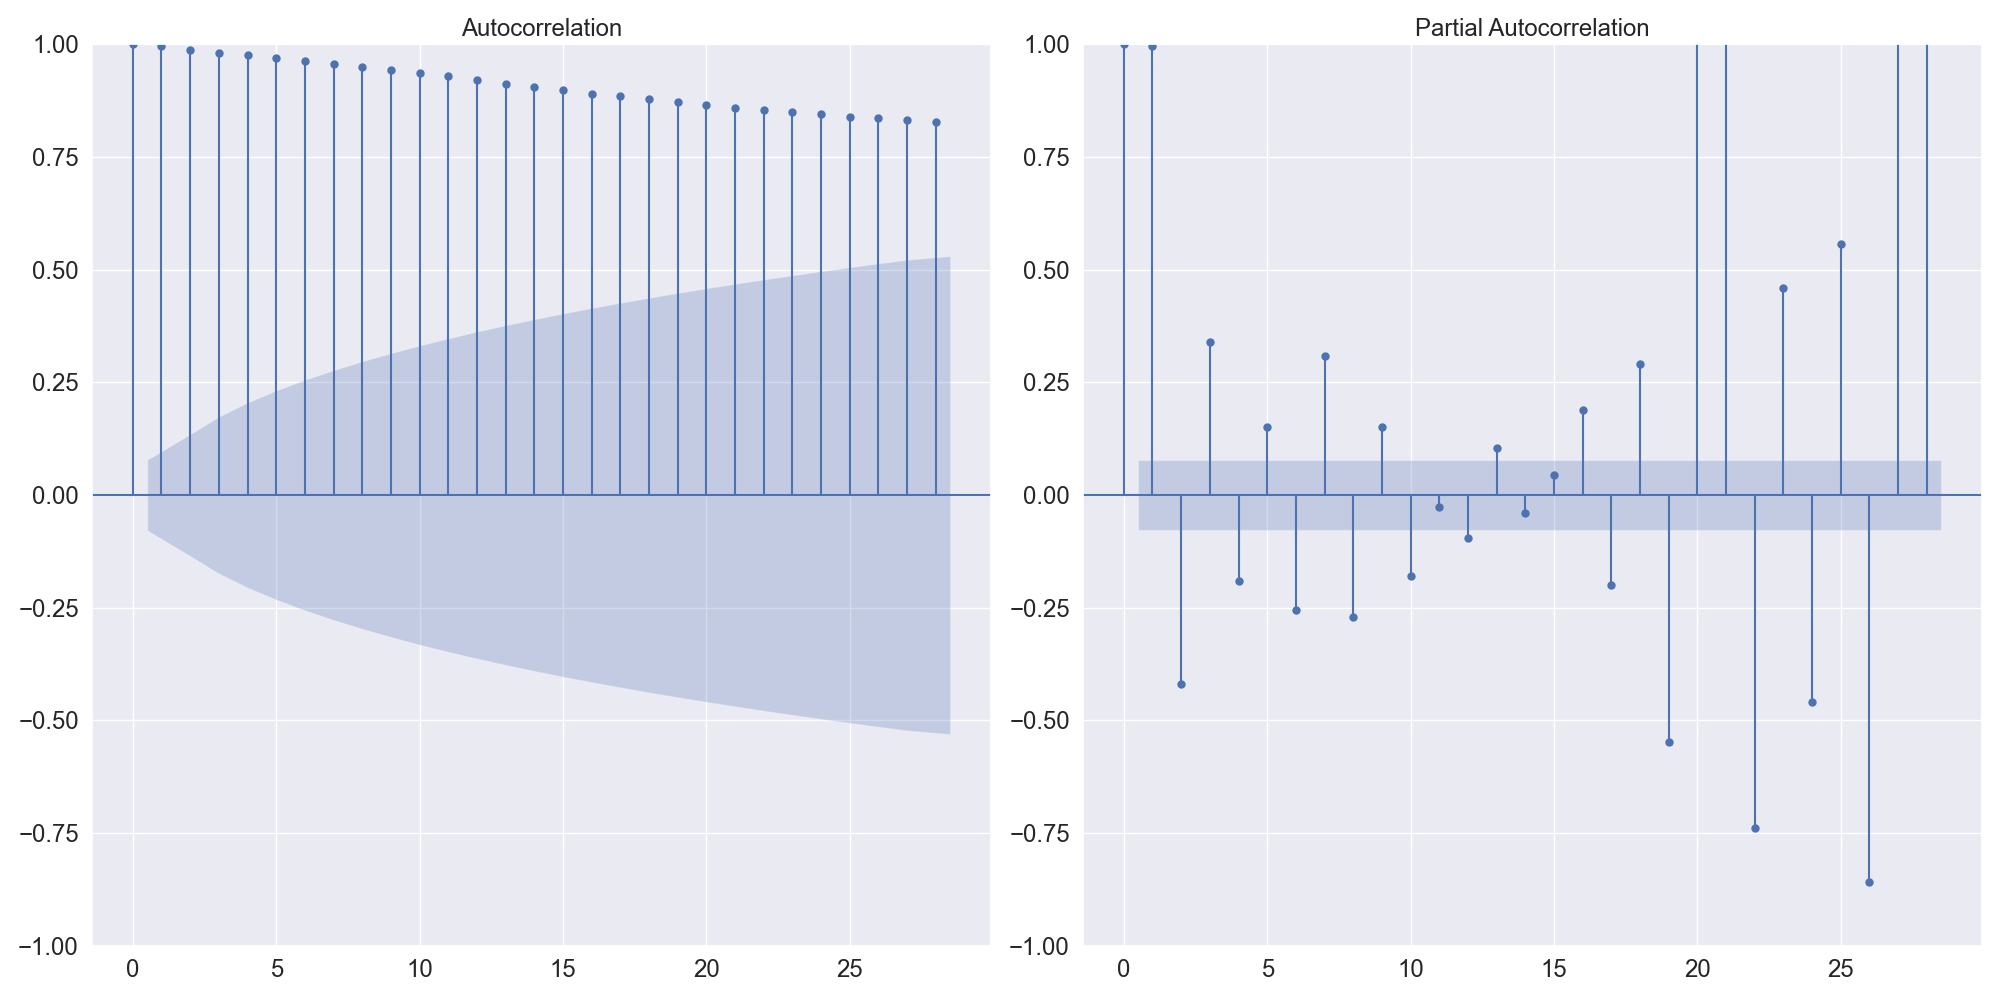
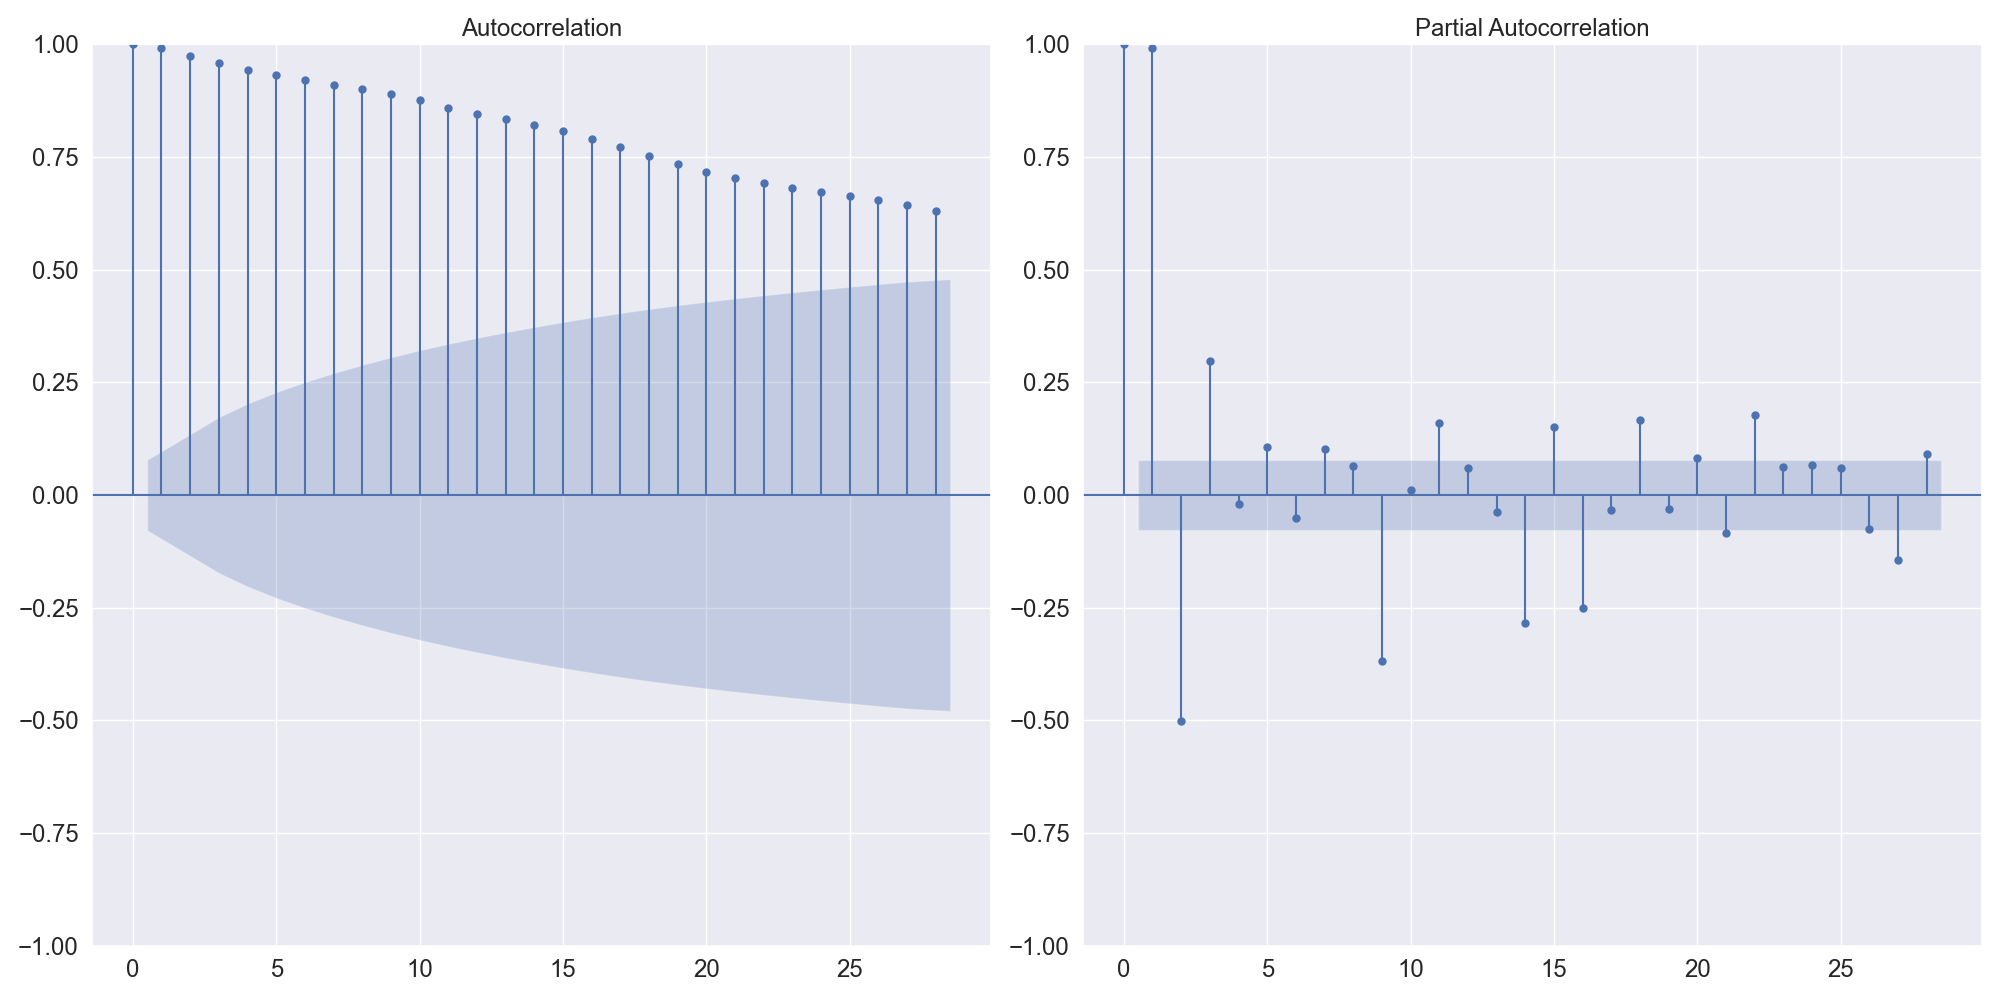
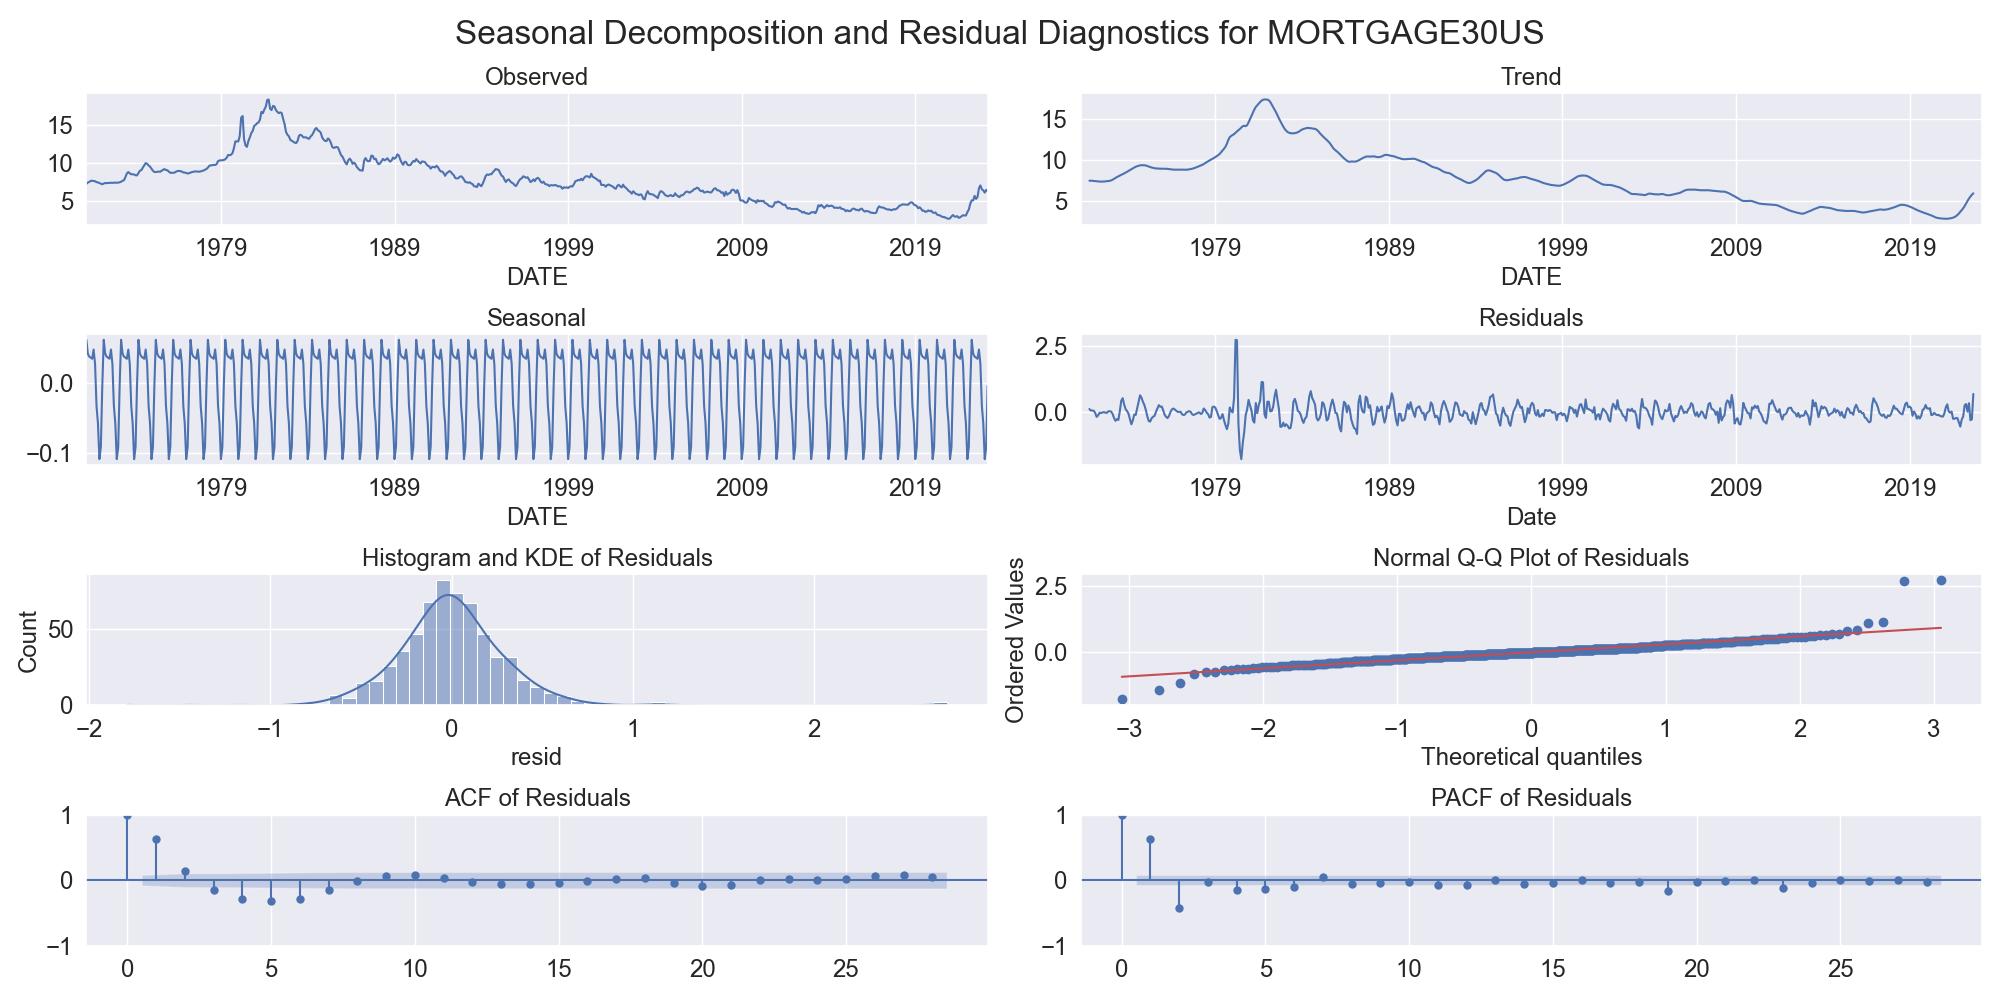
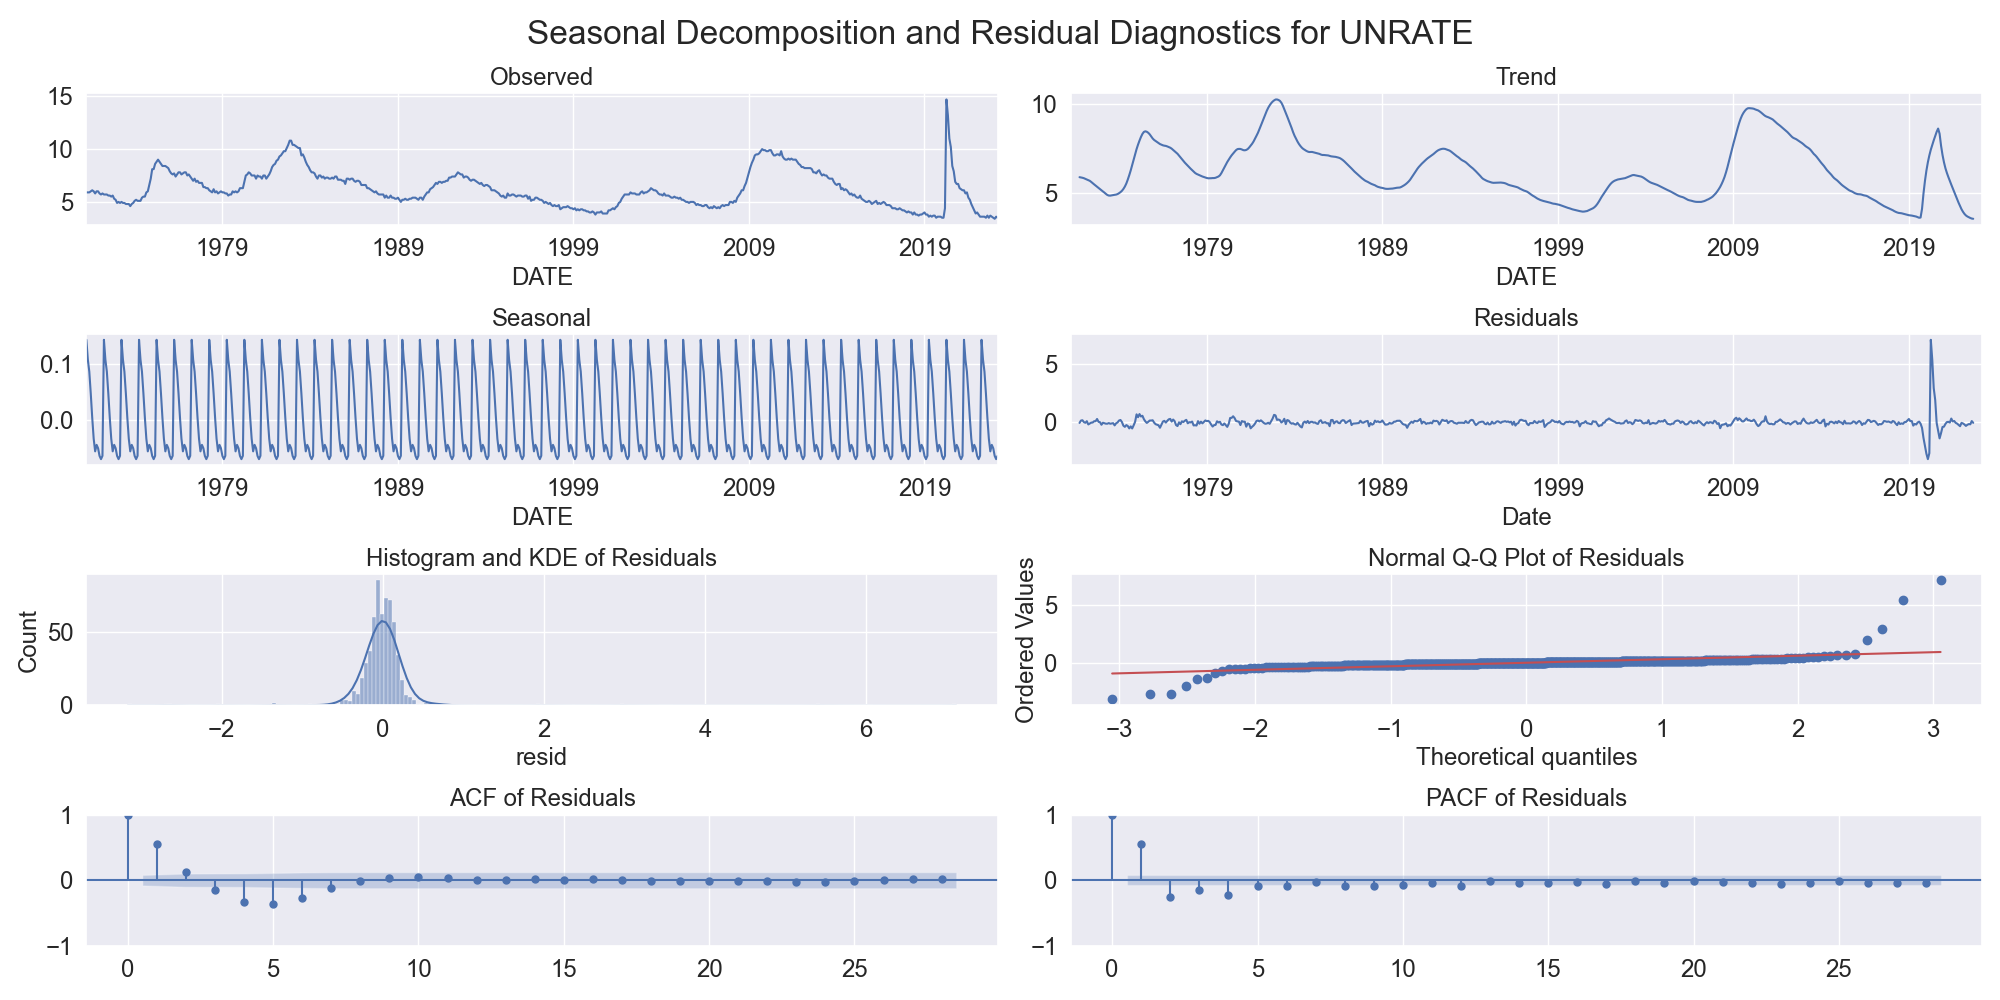
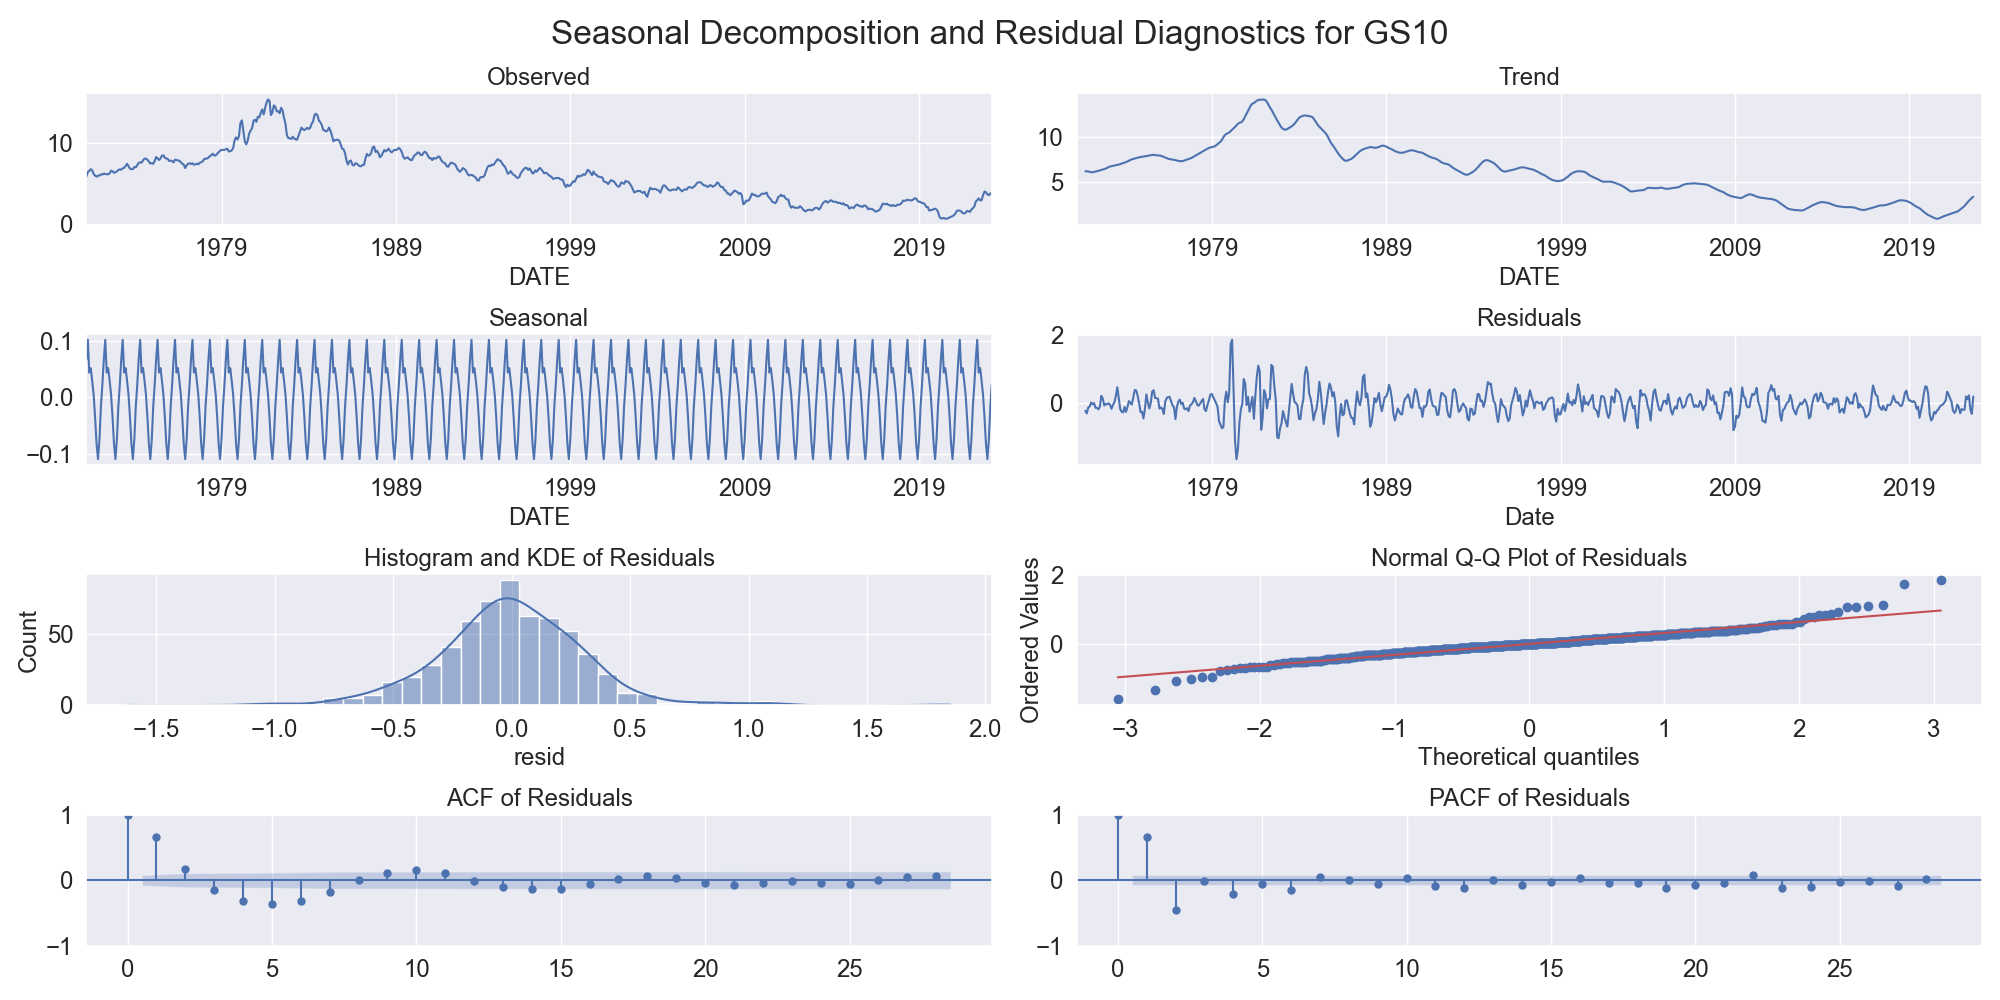
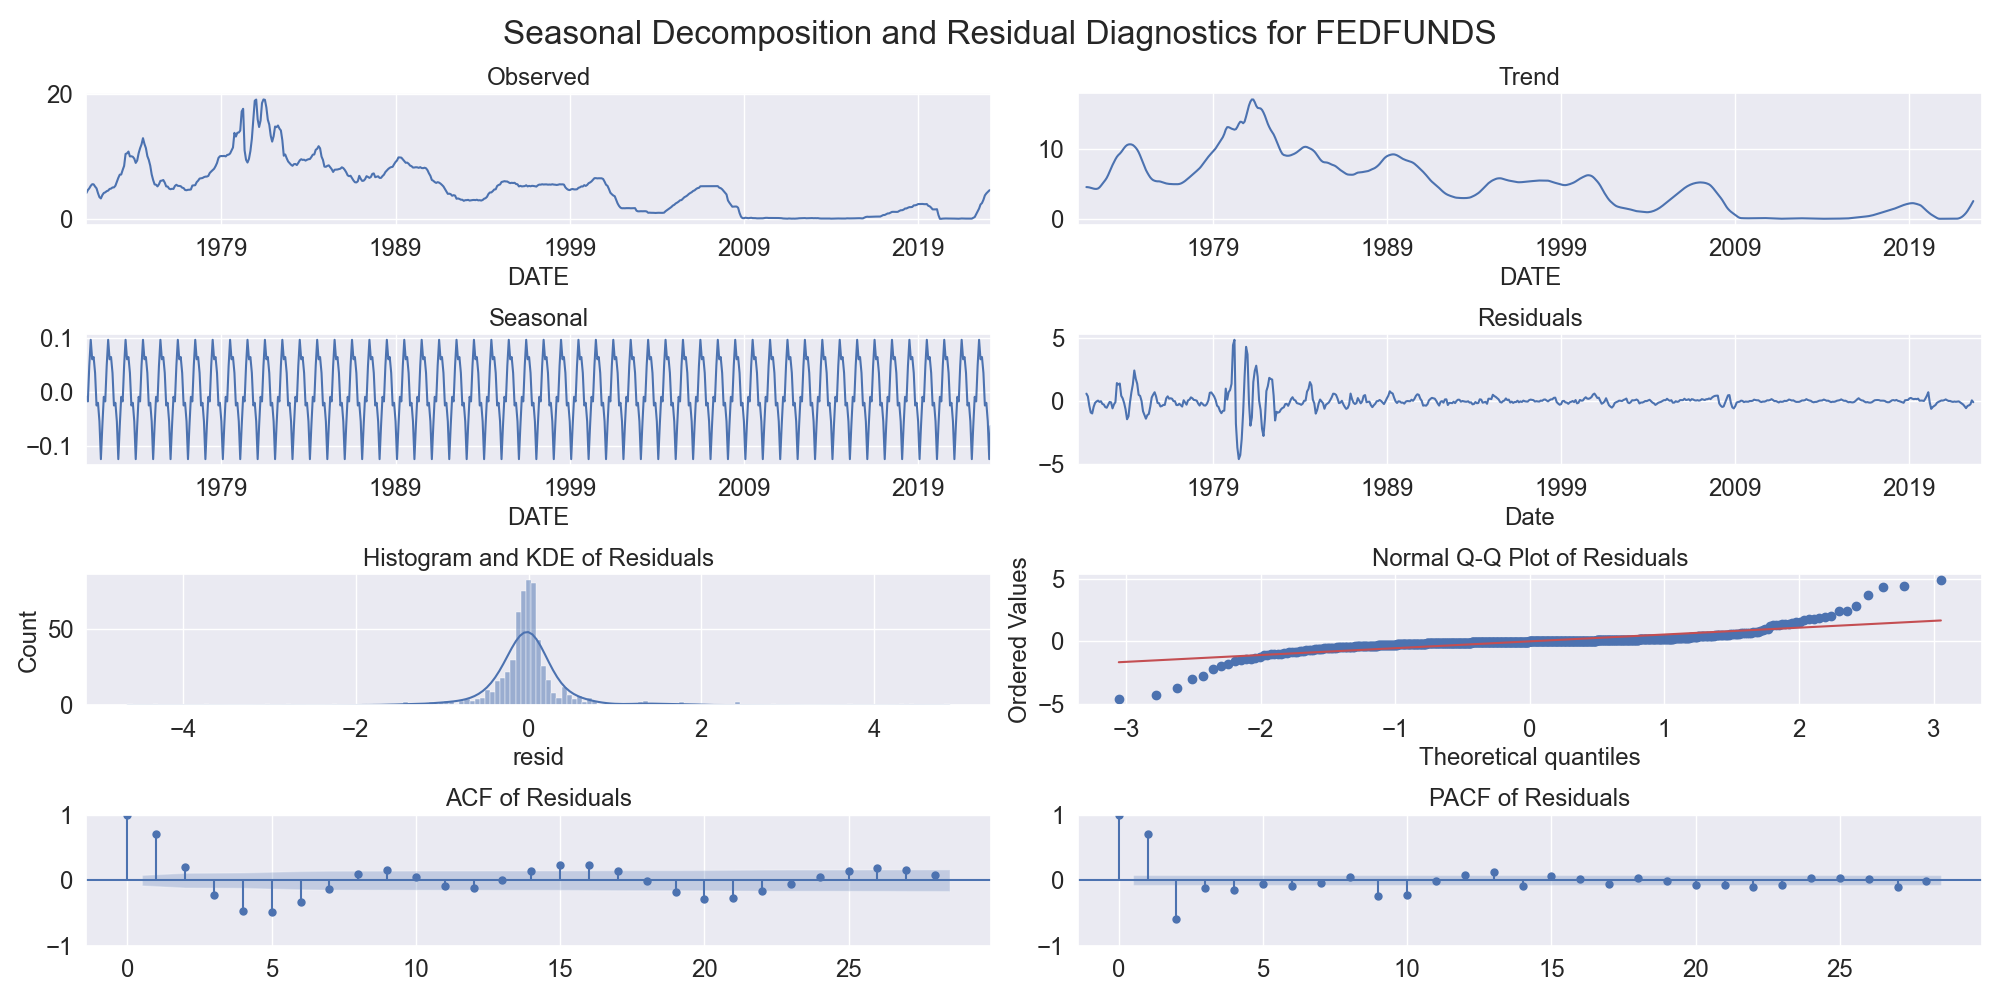
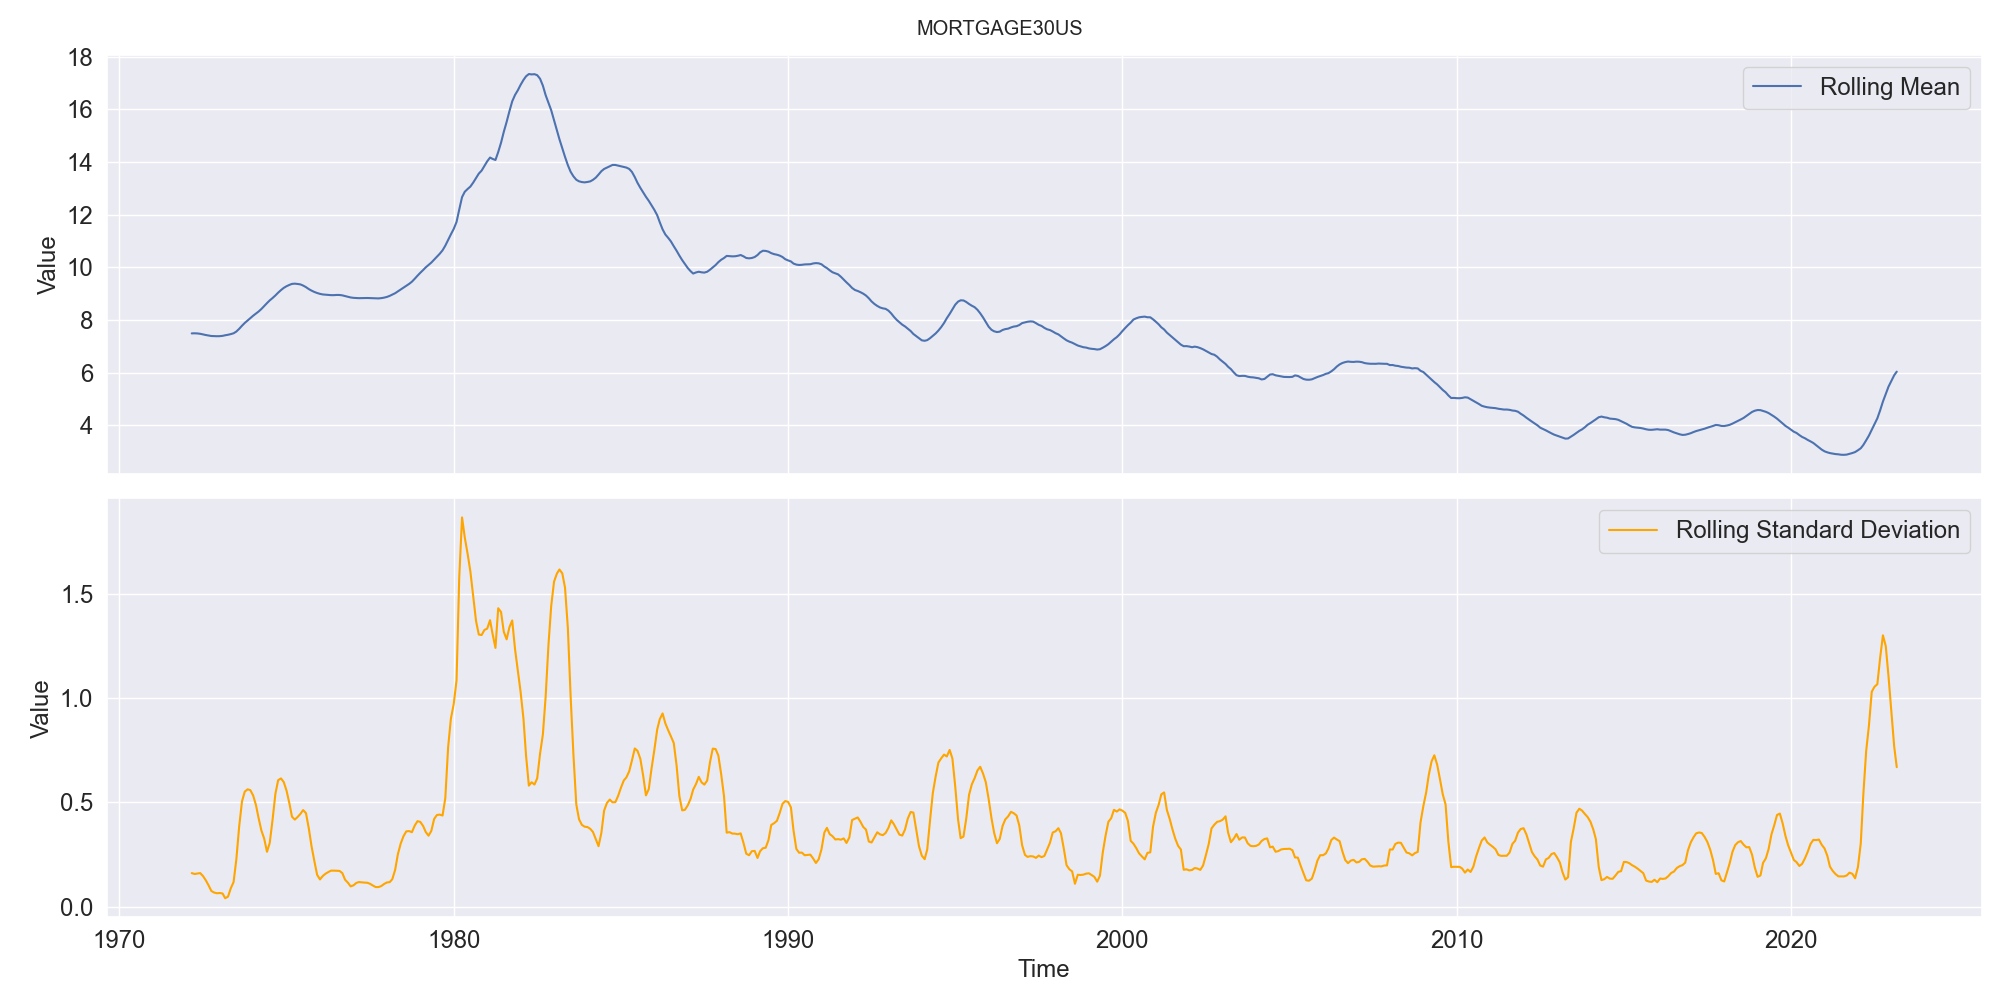
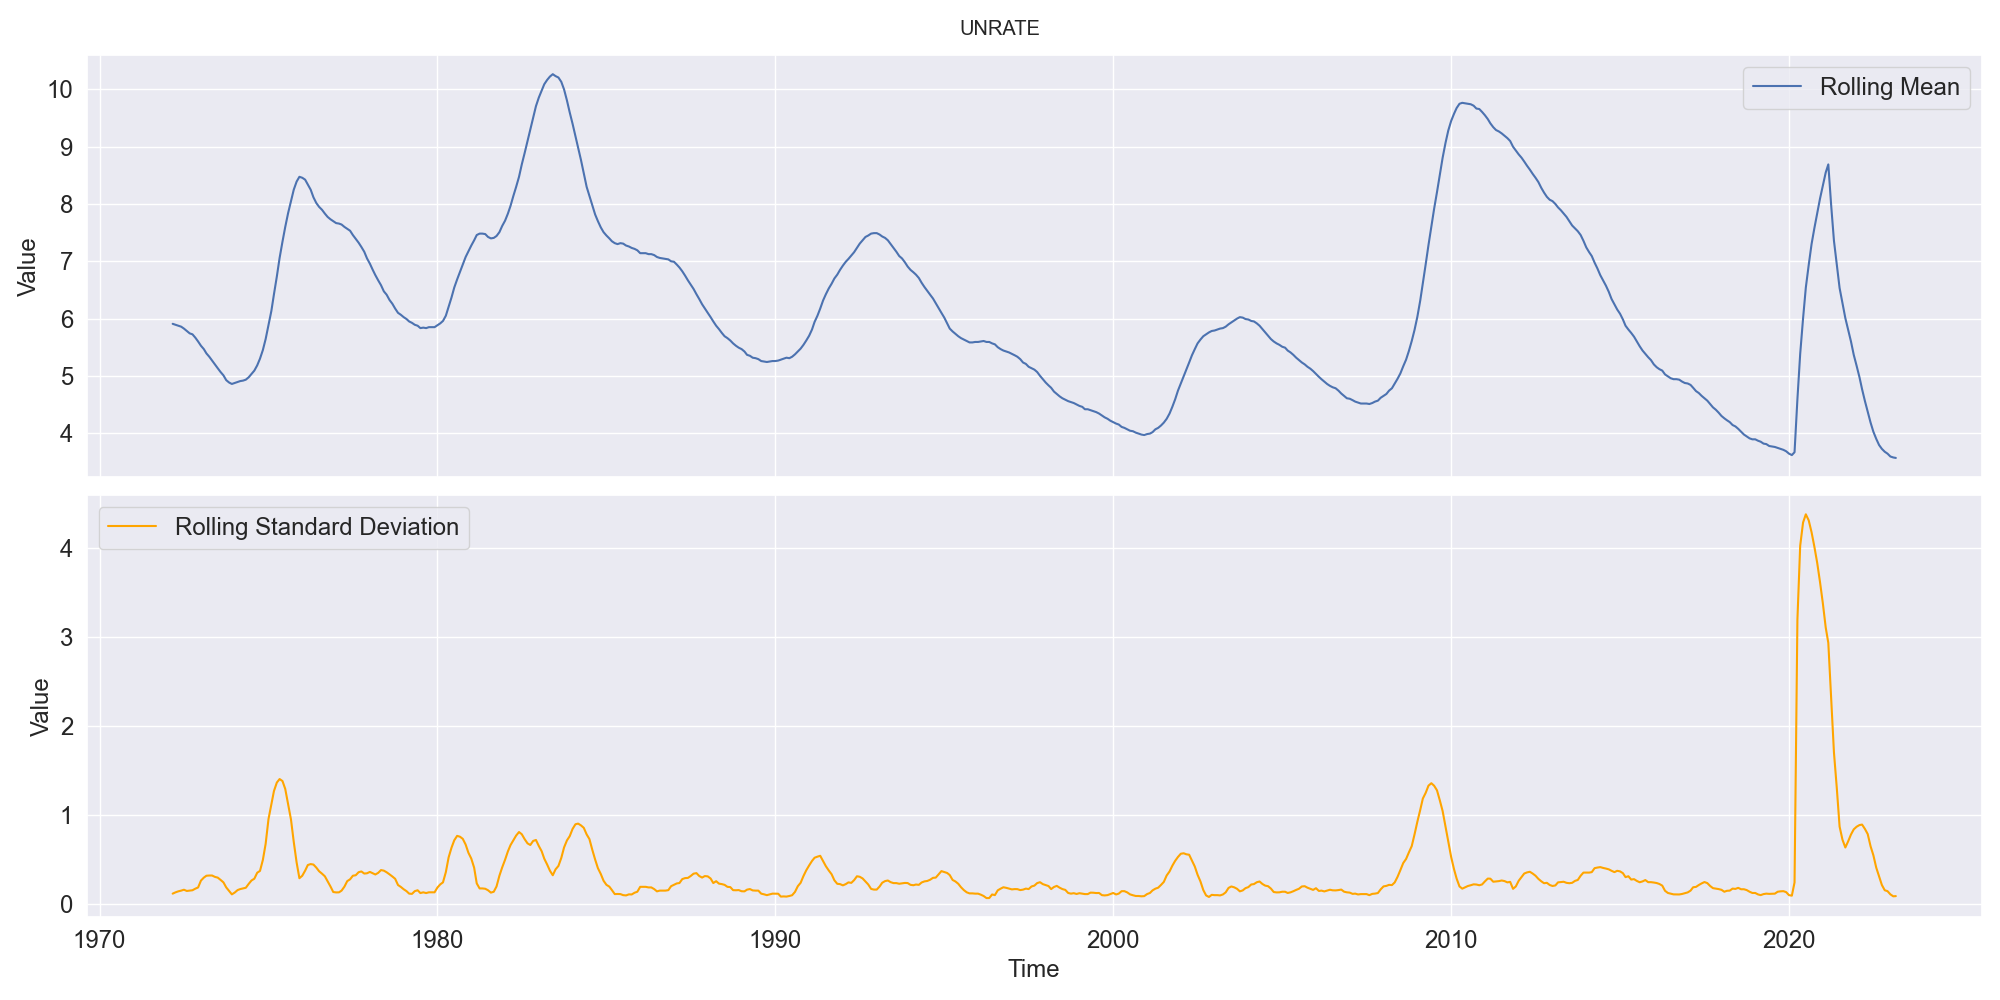
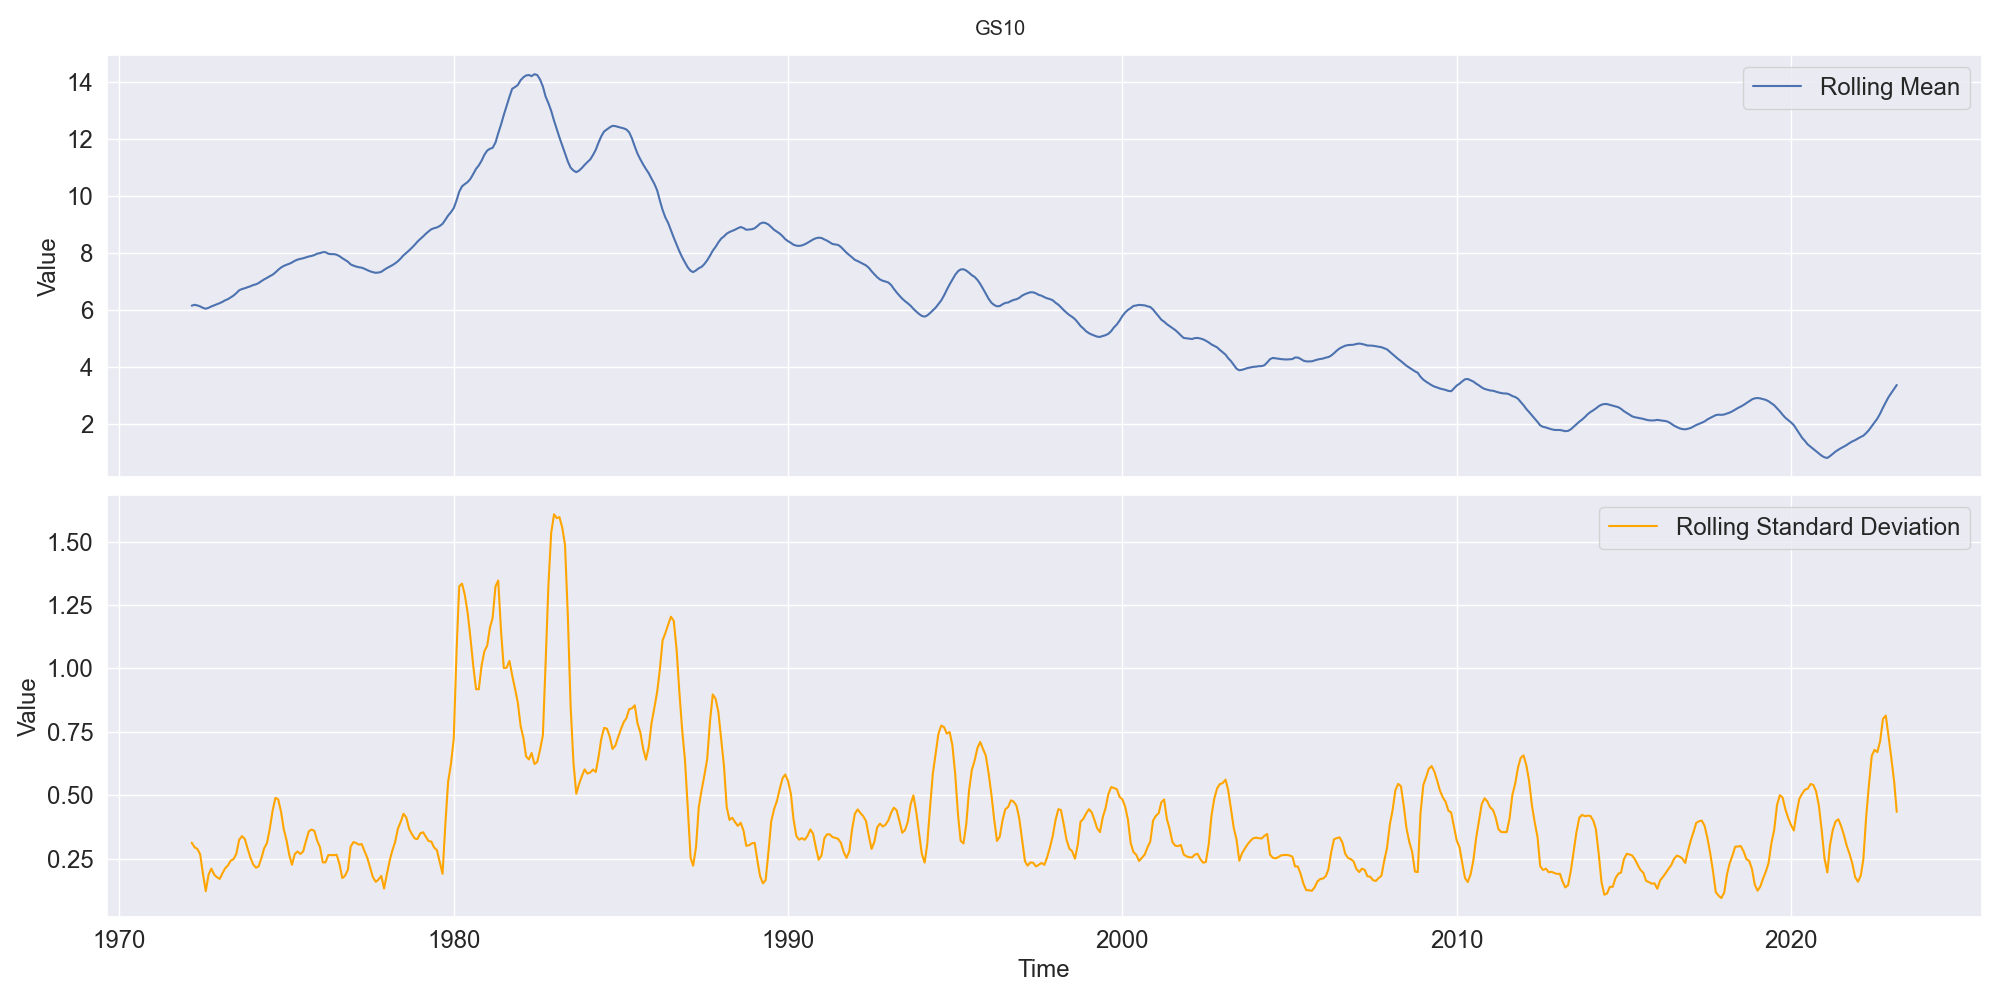
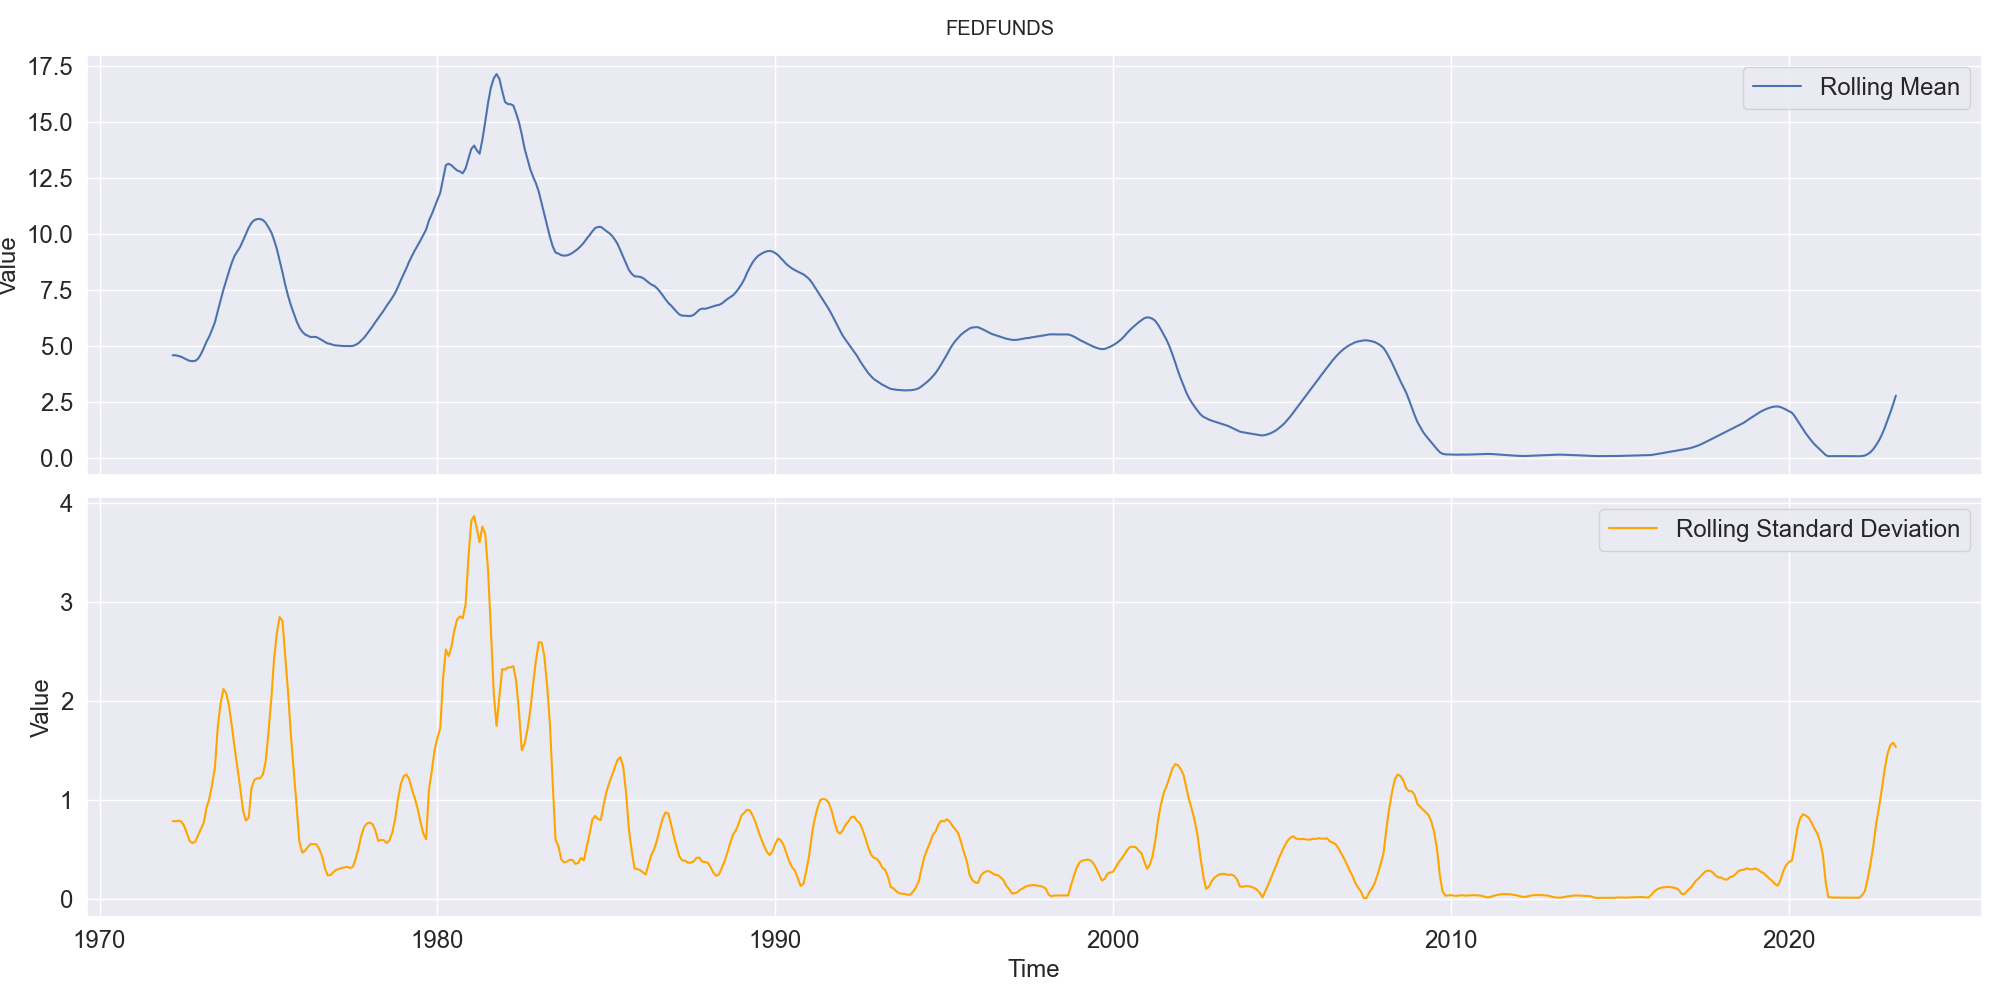

TimeSeriesUnivariate(test_context=TestContext(dataset=Dataset(raw_dataset=            MORTGAGE30US  UNRATE  GS10  FEDFUNDS
DATE                                            
1947-01-01           NaN     NaN   NaN       NaN
1947-02-01           NaN     NaN   NaN       NaN
1947-03-01           NaN     NaN   NaN       NaN
1947-04-01           NaN     NaN   NaN       NaN
1947-05-01           NaN     NaN   NaN       NaN
...                  ...     ...   ...       ...
2022-12-01          6.42     3.5  3.62      4.10
2023-01-01          6.13     3.4  3.53      4.33
2023-02-01          6.50     3.6  3.75      4.57
2023-03-01          6.32     3.5  3.66      4.65
2023-04-01          6.43     NaN  3.46       NaN

[916 rows x 4 columns], fields=[{'id': 'MORTGAGE30US', 'type': 'Numeric'}, {'id': 'UNRATE', 'type': 'Numeric'}, {'id': 'GS10', 'type': 'Numeric'}, {'id': 'FEDFUNDS', 'type': 'Numeric'}], sample=[{'id': 'head', 'data': [{'MORTGAGE30US': nan, 'UNRATE': nan, 'GS10': nan, 'FEDFUNDS': nan}, {

In [10]:
vm.run_test_plan("time_series_univariate", config=test_plan_config, dataset=vm_dataset)

## Multivariate Analysis

In [13]:
vm.test_plans.describe_plan("time_series_multivariate")

Attribute,Value
ID,time_series_multivariate
Name,TimeSeriesMultivariate
Description,Test plan to perform univariate inspection tests.
Required Context,['dataset']
Tests,"ScatterPlot (Metric), LaggedCorrelationHeatmap (Metric), EngleGrangerCoint (Metric)"
Test Plans,[]


In [14]:
test_plan_config = {
    "scatter_plot": {
        "columns": target_column + feature_columns
    },
    "lagged_correlation_heatmap": {
        "target_col": target_column,
        "independent_vars": feature_columns
    },
    "engle_granger_coint": {
        "threshold": 0.05
    },
}


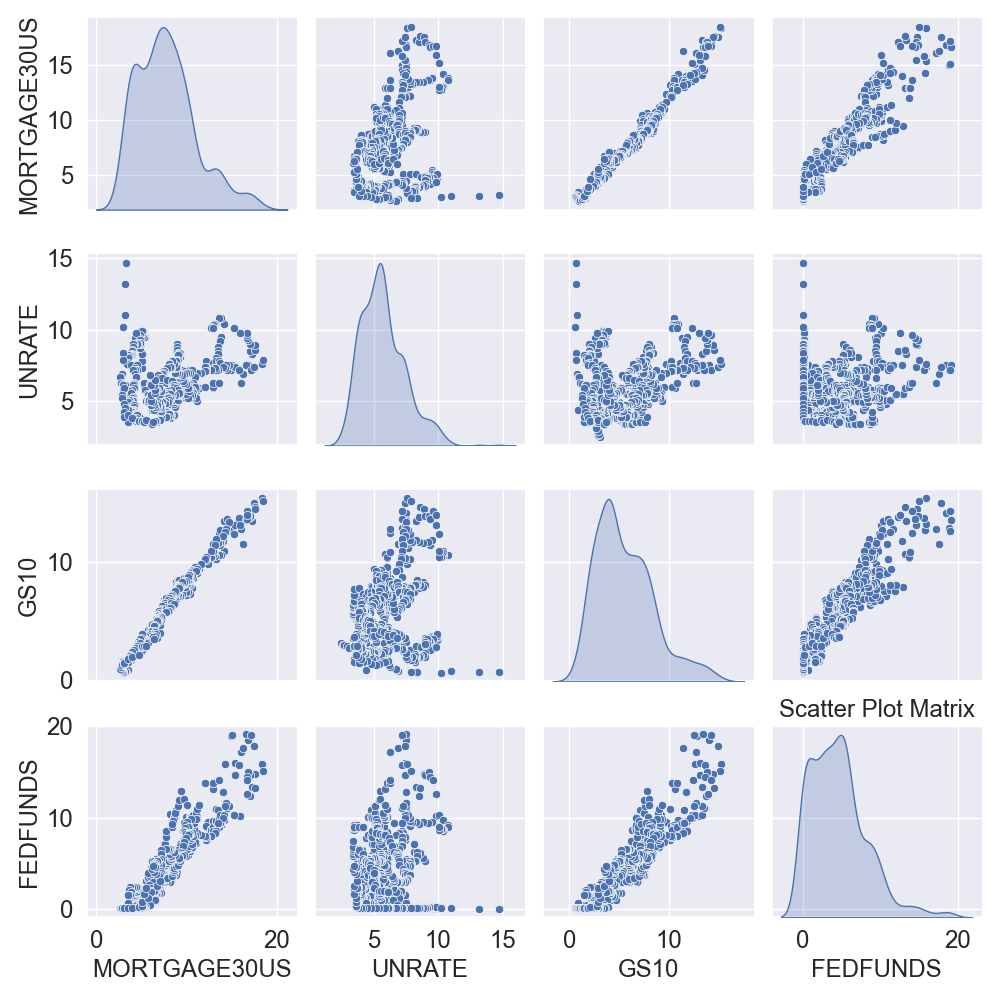
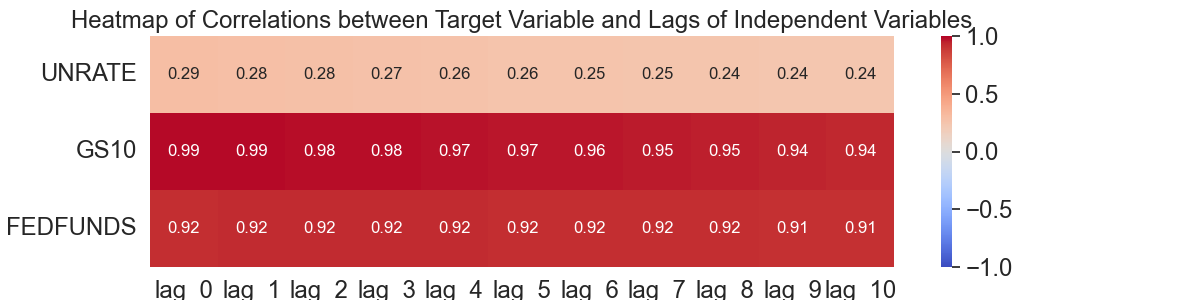

TimeSeriesMultivariate(test_context=TestContext(dataset=Dataset(raw_dataset=            MORTGAGE30US  UNRATE  GS10  FEDFUNDS
DATE                                            
1947-01-01           NaN     NaN   NaN       NaN
1947-02-01           NaN     NaN   NaN       NaN
1947-03-01           NaN     NaN   NaN       NaN
1947-04-01           NaN     NaN   NaN       NaN
1947-05-01           NaN     NaN   NaN       NaN
...                  ...     ...   ...       ...
2022-12-01          6.42     3.5  3.62      4.10
2023-01-01          6.13     3.4  3.53      4.33
2023-02-01          6.50     3.6  3.75      4.57
2023-03-01          6.32     3.5  3.66      4.65
2023-04-01          6.43     NaN  3.46       NaN

[916 rows x 4 columns], fields=[{'id': 'MORTGAGE30US', 'type': 'Numeric'}, {'id': 'UNRATE', 'type': 'Numeric'}, {'id': 'GS10', 'type': 'Numeric'}, {'id': 'FEDFUNDS', 'type': 'Numeric'}], sample=[{'id': 'head', 'data': [{'MORTGAGE30US': nan, 'UNRATE': nan, 'GS10': nan, 'FEDFUNDS': nan},

In [15]:
vm.run_test_plan("time_series_multivariate", config=test_plan_config, dataset=vm_dataset)